In [1]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, linear_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import minimize
import scipy
from mpl_toolkits.mplot3d import Axes3D
# plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.preamble'] = r'\usepackage{cmbright}'

# Stomata stuff

In [2]:
# Constants for A from Manzoni 2011
a1 = 20.3
Kc = 119
Ko = 677
Oconc = 0.21
Rc = 0.7
ca = 400
Gamma = 36.9
a2 = Kc*(1+Oconc/Ko)
psych = 227
Qp = 1500
XX = a1 * Qp / (Qp + psych) / (Rc*ca + a2)

dr = 0.001 # m
Rai = 80 
Zr = 0.3
phi = 10e9/(18*9.81)
#gsr = phi * np.sqrt(Rai/(2*dr*Zr))
#print(gsr)
Kmax = 0.003 # mol/m^2/s/MPa
D = 0.009 # molar VPD mol

In [3]:
# Given values
import math
temperature_Celsius = 25
relative_humidity_percent = 80

# Calculate saturation vapor pressure (e_s)
e_s = 0.611 * math.exp((17.27 * temperature_Celsius) / (temperature_Celsius + 237.3))

# Calculate actual vapor pressure (e_a)
e_a = (relative_humidity_percent / 100) * e_s

# Calculate Vapor Pressure Deficit (VPD)
VPD = e_s - e_a

print(f"VPD at {relative_humidity_percent}% humidity and {temperature_Celsius}°C: {VPD:.4f} kPa")

total_pressure = 101.325  # standard atmospheric pressure in kPa

# Calculate partial pressure of water vapor
partial_pressure_water_vapor = VPD

# Calculate molar fraction of water vapor
molar_fraction_water_vapor = partial_pressure_water_vapor / total_pressure

print(f"Molar Fraction of Water Vapor: {molar_fraction_water_vapor:.6f}")

VPD at 80% humidity and 25°C: 0.6338 kPa
Molar Fraction of Water Vapor: 0.006255


In [4]:
def logistic(x, psi50, k):
    return 1/(1+np.exp(k*(x-psi50)))

In [5]:
def theta_func(psil,psi50k,k):
    return 1-logistic(psil,psi50k,k)

def A_NSL(psil,psis,psi50k,psi50L,k):
        # if psil < psis:
        #         return 0
        return 1/(Kmax/D * logistic(psil,psi50k,k)*(psil-psis) + XX*1.6) * (ca-Gamma) * XX * logistic(psil,psi50k,k) * Kmax/D * logistic(psil,psi50L,k)*(psil-psis)

def Y(psi50k, psil, psis, kK):
    return (1 + np.exp(kK*(psis - psi50k))) /(1 + np.exp(kK*(psil - psi50k)))

def phi(psis,psil,psi50k,kK):
    y = Y(psi50k, psil, psis, kK)
    return Kmax * ( np.abs(psil - psis) + 1/kK * np.log(y))

def phi_og(psis,psil,psi50k, kK):
    return Kmax * (psil - psis) * logistic(psil,psi50k,kK)

def A_new_NSL(psil,psis,psi50k,psi50L,k):
        # if psil < psis:
        #         return 0
        return 1/(1 + XX*1.6 / (phi(psis, psil, psi50k, k)/D)) * (ca-Gamma) * XX * logistic(psil,psi50L,k)

def A_new_noNSL(psil,psis,psi50k,k):
        # if psil < psis:
        #         return 0
        return 1/(1 + XX*1.6 / (phi(psis, psil, psi50k, k)/D)) * (ca-Gamma) * XX * logistic(psil,100,k)

def A_noNSL(psil,psis,psi50k,k):
        # if psil < psis:
        #         return 0
        return 1/(1 + XX*1.6/(Kmax/D * logistic(psil,psi50k,k)*(psil-psis))) * (ca-Gamma) * XX * logistic(psil,psi50k,k)

def Profit_short(psil,psis,psi50k,k,alpha):
        return 1/(logistic(psil,psi50k,k)*(psil-psis) + 1) * logistic(psil,psi50k,k)*(psil-psis) - alpha*psil**2

C:\Users\amatt\AppData\Local\Temp\ipykernel_18408\2912209700.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/(1 + XX*1.6 / (phi(psis, psil, psi50k, k)/D)) * (ca-Gamma) * XX * logistic(psil,psi50L,k)
C:\Users\amatt\AppData\Local\Temp\ipykernel_18408\2912209700.py:22: RuntimeWarning: divide by zero encountered in divide
  return 1/(1 + XX*1.6 / (phi(psis, psil, psi50k, k)/D)) * (ca-Gamma) * XX * logistic(psil,psi50L,k)


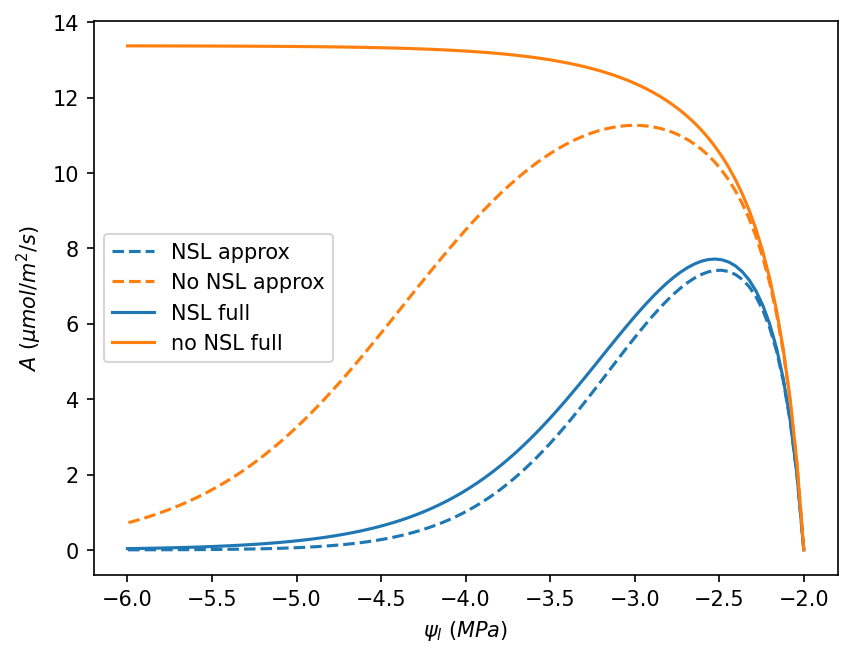

In [6]:
fig, ax = plt.subplots(dpi=150)
pg = 2
x = np.linspace(pg,6,100)

A_new_arr = [A_new_NSL(i, pg, pg+1, 100,2) for i in x]
#

#A_new_arr2 = [A_new(i, pg, pg,2) for i in x]

labels = [str('approx, ' + r'$\psi_{50K} = \psi_s - 1$'),str('integral, ' + r'$\psi_{50K} = \psi_s - 1$'),
          str('approx, ' + r'$\psi_{50K} = \psi_s$'),str('integral, ' + r'$\psi_{50K} = \psi_s$')]

labels2 = [str('NSL approx'),str('No NSL approx'),
          str('NSL full'),str('no NSL full')]



ax.plot(-x,A_NSL(x,pg,pg+1,pg+1,2),label=labels2[0], color = 'tab:blue', linestyle = '--')
ax.plot(-x,A_NSL(x,pg,pg+1,100,2),label=labels2[1], color = 'tab:orange', linestyle = '--')
ax.plot(-x,A_new_NSL(x,pg,pg+1,pg+1,2),label=labels2[2], color = 'tab:blue', linestyle = '-')
ax.plot(-x,A_new_NSL(x,pg,pg+1,100,2),label=labels2[3], color = 'tab:orange', linestyle = '-')

ax.legend()
ylab = r"$A$"+" "+r"$(\mu mol/m^2/s)$"
ax.set_ylabel(ylab)
ax.set_xlabel(r'$\psi_l$' + ' ' + r'($MPa$)')
plt.show()

# ax.plot(x,A_noNSL(x,pg,pg+1,2))
# ax.plot(x,A_noNSL(x,pg,pg+2,2))
# ax.plot(x,A_noNSL(x,pg,pg+3,2))
# ax.plot(x,A_noNSL(x,pg,pg+4,2))

In [7]:

def psiLopt_NSL(psis, psi50k, psi50L, k):
    def A_mod(psil,psis,psi50k,psi50L,k):
        return -1*A_NSL(psil,psis,psi50k,psi50L,k) #+ (1-logistic(psil,psi50k,k))
    # psi50s = np.linspace(psis+0.01,psis+5,100)
    sol = minimize(A_mod,x0=psis+1, args=(psis,psi50k,psi50L,k),bounds=[(psis,20)])
    return sol.x[0]

def psiLopt_noNSL(psis, psi50k, k):
    def A_mod(psil,psis,psi50k,k):
        return -1*A_noNSL(psil,psis,psi50k,k) #+ (1-logistic(psil,psi50k,k))
    # psi50s = np.linspace(psis+0.01,psis+5,100)
    sol = minimize(A_mod,x0=psis+0.1, args=(psis,psi50k,k))
    return sol.x[0]

def psiLopt_prof_short(psis, psi50k, k, alpha):
    def A_mod(psil,psis,psi50k,psi50L,k):
        return -1*Profit_short(psil,psis,psi50k,k,alpha) #+ (1-logistic(psil,psi50k,k))
    # psi50s = np.linspace(psis+0.01,psis+5,100)
    sol = minimize(A_mod,x0=psis+1, args=(psis,psi50k,k,alpha))
    return sol.x[0]

def A_V_J(psiV,psiJ,psil,psik,psis):
    Av = A_NSL(psil,psis,psik,psiV,2)
    Aj = A_NSL(psil,psis,psik,psiJ,2)
    return min(Av,Aj)

In [45]:
# No NSL optimization of psi50K
n = 100
# Investigate x versus y for plots
psis_list = np.linspace(0,10,n)
psi50k_list = np.linspace(0,10,n)

opt_psi_list = np.zeros([n,n])
g_opt_list = np.zeros([n,n])
A_T_opt_list = np.zeros([n,n])
AT_min_cost_list = np.zeros([n,n])
A_opt_list_2 = np.zeros([n,n])
A_plain = np.zeros([n,n])

alpha = 1.5

for i in range(n):
    for j in range(n):
        psil_opt = psiLopt_noNSL(psis_list[i],psi50k_list[j],2)
        opt_psi_list[i,j] = psil_opt
        A_plain[i,j] = A_noNSL(psil_opt,psis_list[i],psi50k_list[j],2)
        A_opt_list_2[i,j] = A_plain[i,j] - alpha*(psi50k_list[j]) 


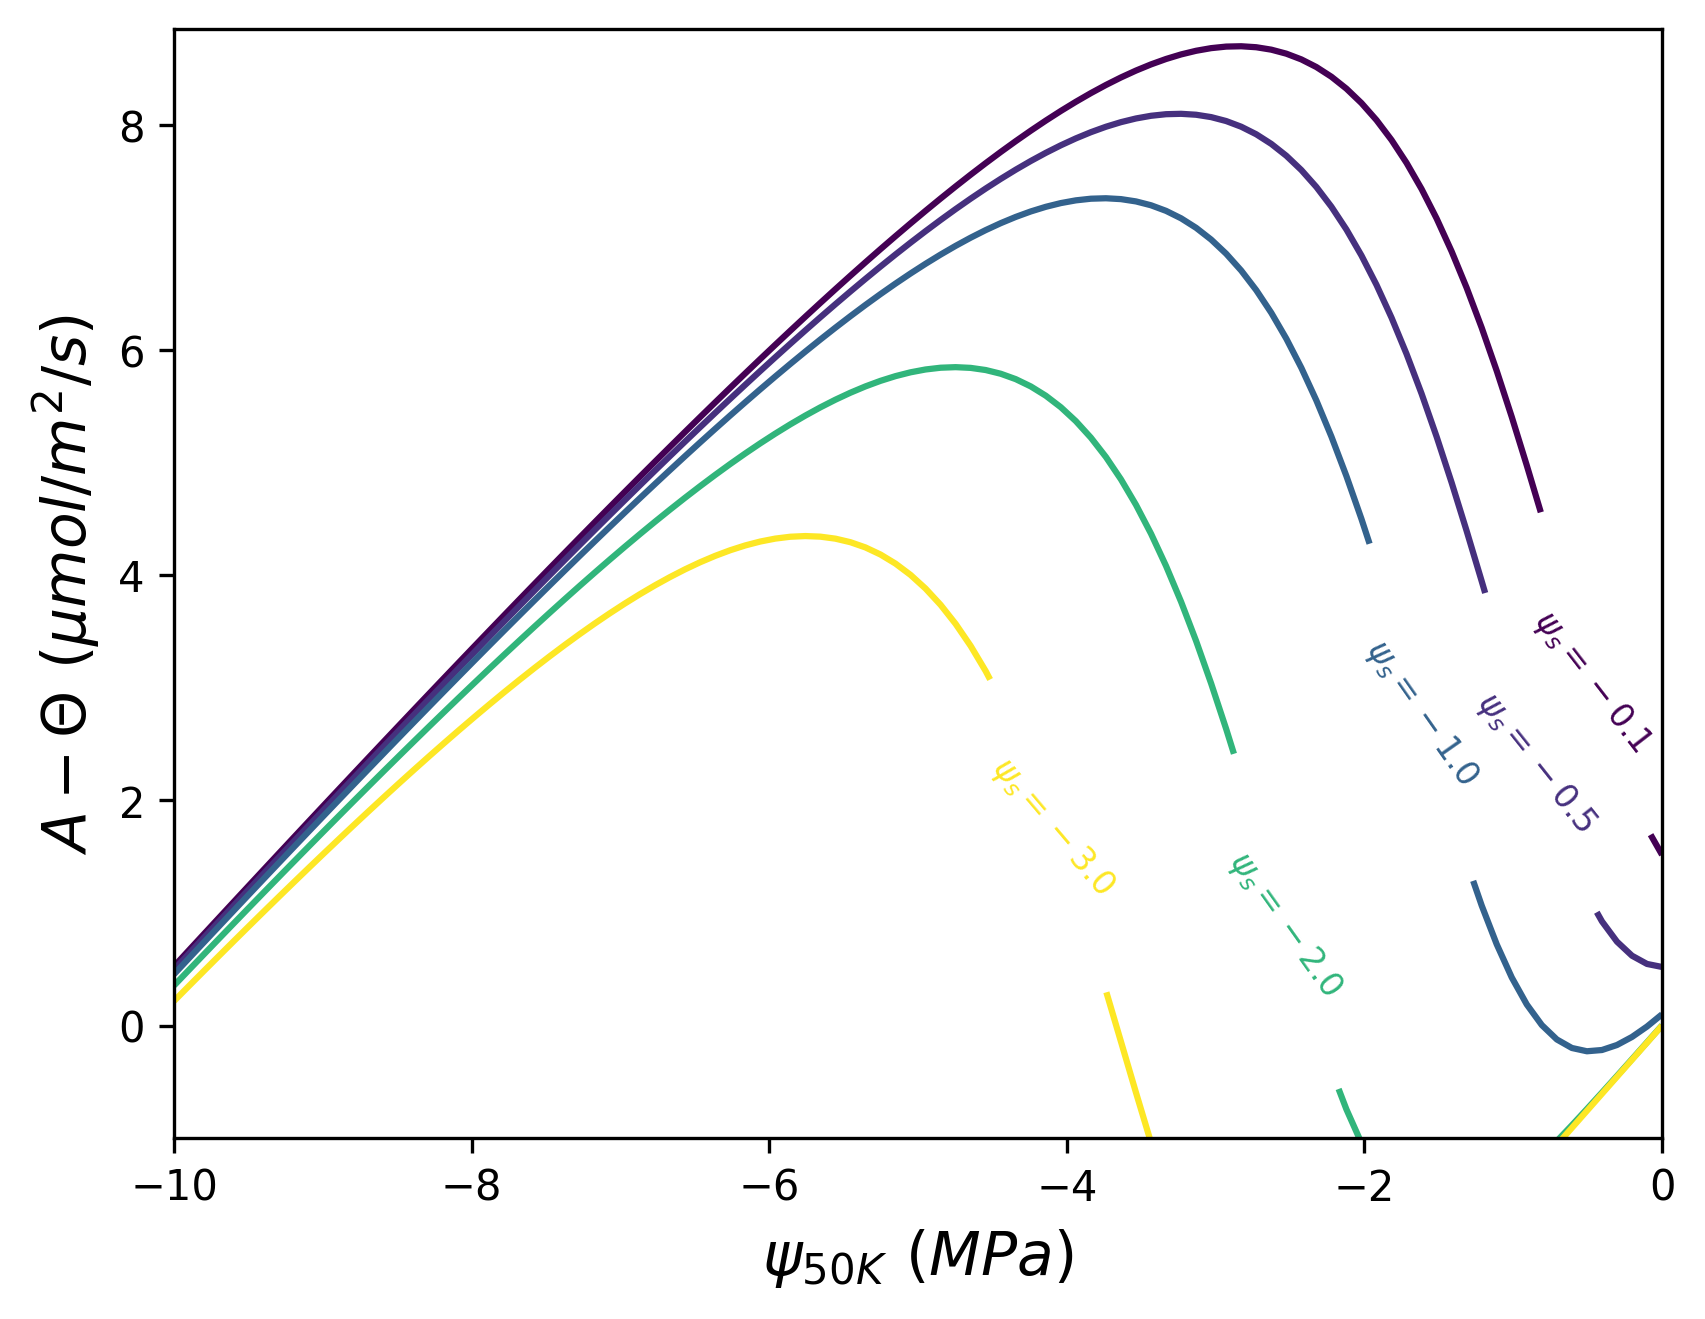

In [60]:
X,Y = np.meshgrid(psis_list,psi50k_list)

levels = [0.1,0.5,1,2,3]

label_dict ={level: r'$\psi_s=-$'f'{level:.1f}' for level in levels}

#label_dict = {0.1 : r'$\psi_s$ = 0.1$'}

fig, ax = plt.subplots(dpi=300)

contour_plot = ax.contour(-X, A_opt_list_2, Y,levels=levels)  # Use a different colormap if needed

manual_positions = [(-4,2),(-2,2),(-2,2),(-1,2),(-0.5,3)]
ax.clabel(contour_plot, inline=True, fontsize=8, manual=manual_positions,fmt=label_dict)  # Add labels to contours

# Change the font properties of ylabel and xlabel
ylab = r"$A-\Theta$"+" "+r"$(\mu mol/m^2/s)$"
psilab = r'$\psi_{50K}$'+ " "+ r'$(MPa)$'
ax.set_ylabel(ylab, fontdict={'size': 'x-large', 'weight': 'bold'})#, 'family': 'serif'})
ax.set_xlabel(psilab, fontdict={'size': 'x-large', 'weight': 'bold'})#, 'family': 'serif'})

ax.set_ylim(-1)
# Add colorbar for better interpretation
#cbar = plt.colorbar(contour_plot, ax=ax)
#cbar.set_label('Your Colorbar Label', rotation=270, labelpad=15, fontdict={'size': 'large', 'weight': 'bold', 'family': 'serif'})

# Adjust layout for better spacing
#plt.tight_layout()

# Enabling LaTeX rendering for text elements
#mpl.rcParams['text.usetex'] = True

# Adjusting global font properties for LaTeX
#mpl.rcParams['text.latex.preamble'] = r'\usepackage{cmbright}'  # Example: Use Computer Modern Bright font

# Display the plot
plt.show()

In [47]:
n=100
psiK_list = np.linspace(0,13,n)
psiL_list = np.linspace(0,10,n)
psiL_opt_list = np.zeros([n,n])
X, Y = np.meshgrid(psiK_list,psiL_list)
Alist_2D = np.zeros([n,n])
Alist_2D_2 = np.zeros([n,n])

k_test = 2
k_test_2 = 10

psis_temp = 1
for i in range(n):
    for j in range(n):
        psil_opt = psiLopt_NSL(psis_temp,psiK_list[i],psiL_list[j],k_test)
        psiL_opt_list[i,j] = psil_opt
        x = A_NSL(psil_opt,psis_temp,psiK_list[i],psiL_list[j],k_test)
        Alist_2D[i,j] = x


for i in range(n):
    for j in range(n):
        psil_opt = psiLopt_NSL(psis_temp,psiK_list[i],psiL_list[j],k_test_2)
        psiL_opt_list[i,j] = psil_opt
        x = A_NSL(psil_opt,psis_temp,psiK_list[i],psiL_list[j],k_test_2)
        Alist_2D_2[i,j] = x


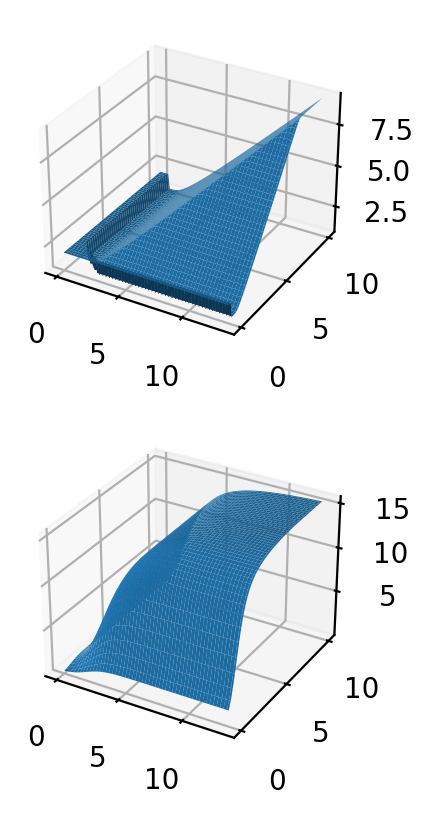

In [48]:
fig, ax = plt.subplots(2,subplot_kw={"projection": "3d"},dpi=200)
ax[0].plot_surface(X,Y,psiL_opt_list)
ax[1].plot_surface(X,Y,Alist_2D)

plt.show()

In [49]:
import pandas as pd
df = pd.read_csv("Default Dataset.csv",names=['psi50K','psi50L'])

[1.75297149]


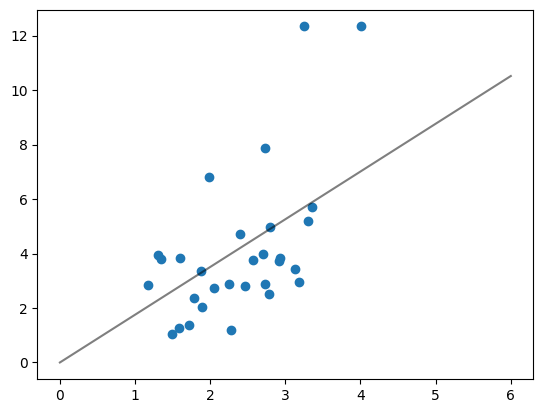

In [50]:

psi50L_train = np.reshape(df['psi50L'], (len(df['psi50L']), 1))

x_test = np.linspace(0, 6, 100)

regr = linear_model.LinearRegression(fit_intercept=False)

regr.fit(psi50L_train, df['psi50K'])

print(regr.coef_)
psi50L_pred = regr.predict(x_test.reshape(-1,1) )

fig, ax = plt.subplots()
ax.scatter(df['psi50L'], df['psi50K'])

plt.plot(x_test, psi50L_pred, color='black', alpha=0.5)

In [51]:
regr.score(psi50L_train, df['psi50K'])

0.32254858011981635

In [52]:

# psi50K_train = np.reshape(df['psi50K'], (len(df['psi50K']), 1))

# x_test = np.linspace(0, max(df['psi50K']), 100)

# regr = linear_model.LinearRegression()#fit_intercept=False)

# regr.fit(psi50K_train, df['psi50L'])

# print(regr.coef_)
# psi50K_pred = regr.predict(x_test.reshape(-1,1) )

# fig, ax = plt.subplots()
# ax.scatter(df['psi50K'], df['psi50L'])

# plt.plot(x_test, psi50K_pred, color='black', alpha=0.5)

In [53]:
regr.intercept_

0.0

In [54]:
RSS = np.sum((df['psi50K']*regr.coef_[0]+regr.intercept_-df['psi50L'])**2)

TSS = np.sum((df['psi50L']-np.mean(df['psi50L']))**2)

Rsquared = 1 - RSS/TSS

print(Rsquared)

-82.18100208027919


In [55]:
# regr.score(psi50K_train, df['psi50L'])

[2.03708626]


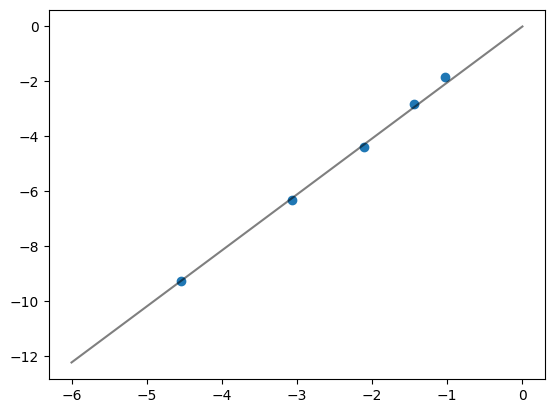

In [56]:
y_sample = [
-1.8428184281842839,
-2.8319783197831985, 
-4.37669376693767, 
-6.300813008130081, 
-9.254742547425476]
x_sample = [
 -1.0301624129930393,
-1.447795823665893,
-2.102088167053364,
-3.062645011600928,
 -4.538283062645011
]

opt_train = np.reshape(x_sample,(len(x_sample),1))
opt_test = np.linspace(-6,0,50).reshape(-1,1)

regr2 = linear_model.LinearRegression(fit_intercept=False)

regr2.fit(opt_train, y_sample)


print(regr2.coef_)
y_pred = regr2.predict(opt_test)

fig, ax = plt.subplots()
ax.scatter(x_sample, y_sample)

plt.plot(opt_test, y_pred, color='black', alpha=0.5)


In [57]:
RSS = np.sum((df['psi50L']*regr2.coef_[0]-df['psi50K'])**2)

TSS = np.sum((df['psi50K']-np.mean(df['psi50K']))**2)

Rsquared = 1 - RSS/TSS

print(Rsquared)

0.25324888022545455


In [58]:
# fig, axs = plt.subplots(1,2,figsize=(10,5),dpi=100)
# levels = [1,2,3,4,5,6,7,8,9,10,11,12,13]
# levels = [4,8,12,14,15]

# axs[0].contour(-X,-Y,Alist_2D,levels=levels)
# axs[1].contour(-X,-Y,Alist_2D_2,levels=levels)
# x = np.linspace(-12.8,0,100)

# for i in range(len(axs)):
#     ax = axs[i]


#     ax.plot(x,-2.9-x,linestyle='--',color='k',linewidth=0.7,label='isocost')
#     ax.plot(x,-6.5-x,linestyle='--',color='k',linewidth=0.7)
#     ax.plot(x,-9.4-x,linestyle='--',color='k',linewidth=0.7)

#     ax.plot(-1*x_test, -1*psi50K_pred, label='best fit (no intercept)')

#     ax.plot(opt_test,y_pred,label='optimal trajectory',color='black')

#     ax.scatter(-1*np.array(df['psi50K']),-1*np.array(df['psi50L']),marker='.')

#     ax.set_xlabel(r'$\psi_{50K}$',fontsize='xx-large')
#     ax.set_ylabel(r'$\psi_{50L}$',fontsize='xx-large')

#     ax.legend()
#     ax.set_ylim(top=0)
#     ax.set_xlim(right=0)

# axs[0].plot(2*x,x)    
# axs[1].plot(1.82*x,x)    

# plt.show()

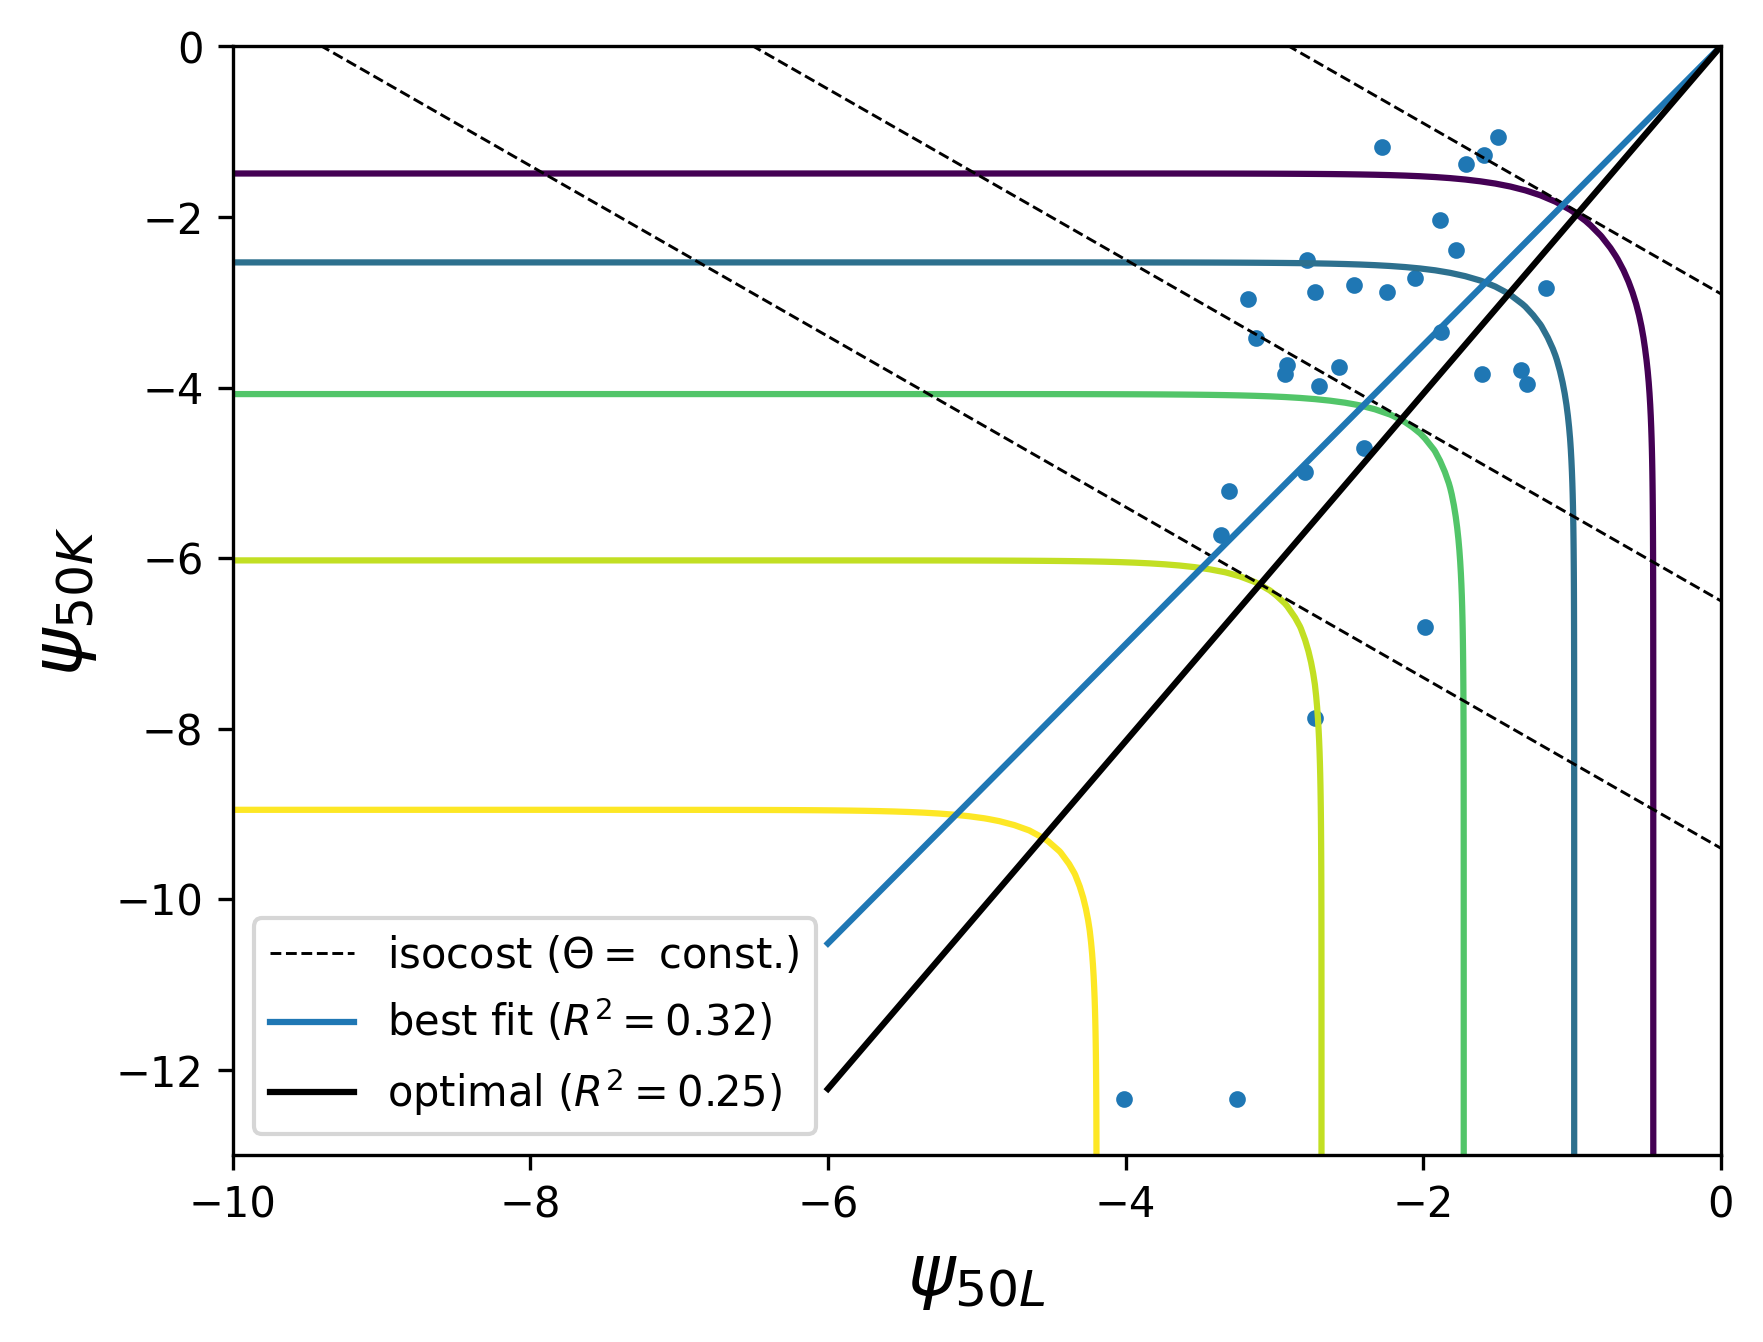

[1.75297149]
[2.03708626]


In [59]:
fig, ax = plt.subplots(dpi=300)
levels = [1,2,3,4,5,6,7,8,9,10,11,12,13]
levels = [4,8,12,14,15]

ax.contour(-Y,-X,Alist_2D,levels=levels)
x = np.linspace(-10,0,100)

ax.plot(x,-2.9-x,linestyle='--',color='k',linewidth=0.7,label='isocost (' + r'$\Theta =$' + " const.)")
ax.plot(x,-6.5-x,linestyle='--',color='k',linewidth=0.7)
ax.plot(x,-9.4-x,linestyle='--',color='k',linewidth=0.7)

ax.plot(-1*x_test, -1*psi50L_pred, label='best fit ('+r'$R^2=0.32$)')

ax.plot(opt_test,y_pred,label='optimal ('+r'$R^2=0.25$)',color='black')

ax.scatter(-1*np.array(df['psi50L']),-1*np.array(df['psi50K']),marker='.')

ax.set_xlabel(r'$\psi_{50L}$',fontsize='xx-large')
ax.set_ylabel(r'$\psi_{50K}$',fontsize='xx-large')

ax.legend()
ax.set_ylim(top=0)
ax.set_xlim(right=0)
plt.show()

print(regr.coef_)
print(regr2.coef_)

NameError: name 'psi50K_pred' is not defined

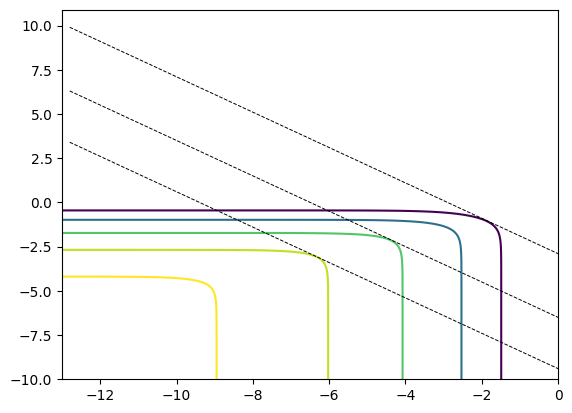

In [24]:
# # Redo it but with L on the x axis

# fig, ax = plt.subplots(dpi=100)
# levels = [1,2,3,4,5,6,7,8,9,10,11,12,13]
# levels = [4,8,12,14,15]

# ax.contour(-X,-Y,Alist_2D,levels=levels)
# x = np.linspace(-12.8,0,100)

# ax.plot(x,-2.9-x,linestyle='--',color='k',linewidth=0.7,label='isocost')
# ax.plot(x,-6.5-x,linestyle='--',color='k',linewidth=0.7)
# ax.plot(x,-9.4-x,linestyle='--',color='k',linewidth=0.7)

# ax.plot(-1*x_test, -1*psi50K_pred, label='best fit (no intercept)')

# ax.plot(opt_test,y_pred,label='optimal trajectory',color='black')

# ax.scatter(-1*np.array(df['psi50K']),-1*np.array(df['psi50L']),marker='.')

# ax.set_xlabel(r'$\psi_{50K}$',fontsize='xx-large')
# ax.set_ylabel(r'$\psi_{50L}$',fontsize='xx-large')

# ax.legend()
# ax.set_ylim(top=0)
# ax.set_xlim(right=0)
# plt.show()

In [36]:
def A_mins(input1, input2):
    return min(input1,input2)

def A_V_J(psiV,psiJ,psil,psik,psis):
    Av = A_NSL(psil,psis,psik,psiV,2)
    Aj = A_NSL(psil,psis,psik,psiJ,2)
    return min(Av,Aj)

def psi_VJ_opt(psiV,psiJ,psik,psis):
    def A_mod(psil,psiV,psiJ,psik,psis):
        return -1*A_V_J(psiV,psiJ,psil,psik,psis) #+ (1-logistic(psil,psi50k,k))
    # psi50s = np.linspace(psis+0.01,psis+5,100)
    sol = minimize(A_mod,x0=psis+1, args=(psiV,psiJ,psik,psis),bounds=[(psis,20)])
    return sol.x[0]

A_mins_2D = np.zeros([n,n])

#psi50J = [-1*psi50J[i] for i in range(len(psi50J))]
#psi50V = [-1*psi50V[i] for i in range(len(psi50V))]
x = np.linspace(0,8,100)

for i in range(n):
    for j in range(n):
        psil_opt = psi_VJ_opt(x[i],x[j],2,1)
        A_mins_2D[i,j] = A_V_J(x[i],x[j],psil_opt,2,1)


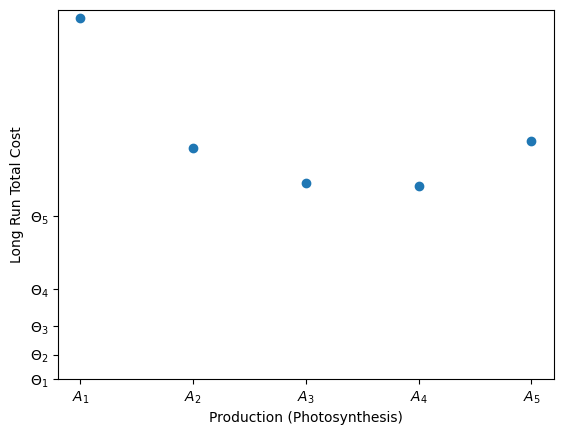

In [37]:
TC1 = [3.6,5,6.6,8.7,12.8]
out1 = [0.15,0.3,0.45,0.6,0.75]
TC2 = [7.7,9.1,10.65,12.9,16.9]

Avg_cost = [TC1[i]/out1[i] for i in range(len(TC1))]

x_new = np.linspace(0, 0.75, 50)
bspline = scipy.interpolate.make_interp_spline(out1, TC1)
y_new = bspline(x_new)

fig, ax = plt.subplots()
#ax.plot(out1,TC1,label='wet soil')
#ax.plot(x_new,y_new)
ax.scatter(out1,Avg_cost)
#ax.plot(out1,TC2,label='dry soil')
ax.set_ylabel("Long Run Total Cost")
ax.set_xlabel("Production (Photosynthesis)")
#ax.legend()
ax.set_yticks(TC1)
ax.set_yticklabels([r'$\Theta_1$',r'$\Theta_2$',r'$\Theta_3$',r'$\Theta_4$',r'$\Theta_5$'],fontsize=10)

ax.set_xticks(out1)
strs = [r'$A_1$', r'$A_2$', r'$A_3$', r'$A_4$',r'$A_5$']
ax.set_xticklabels(strs,fontsize=10)

#ax.spines.top : False
#ax.set_xtickslabels([0.15,r'$A_3$',r'$A_5$'])

# DECREASING RETURN TO SCALE
plt.show()

## The other hydraulic curve



In [38]:
def Y(psi50k, psil, psis, kK):
    return (1 + np.exp(kK*(psis - psi50k))) /(1 + np.exp(kK*(psil - psi50k)))

def phi(psis,psil,psi50k,kK):
    y = Y(psi50k, psil, psis, kK)
    return Kmax * ( np.abs(psil - psis) + 1/kK * np.log(y))

def phi_og(psis,psil,psi50k, kK):
    return Kmax * (psil - psis) * logistic(psil,psi50k,kK)

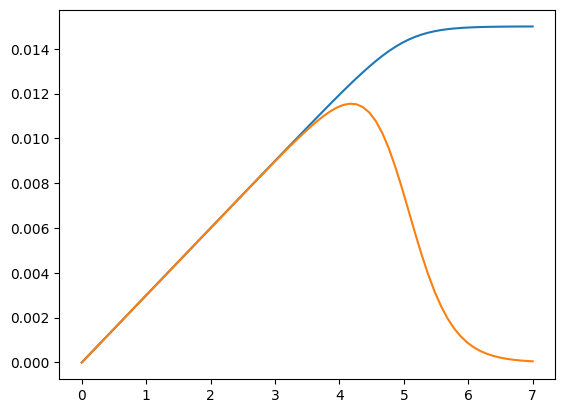

In [39]:
psis_temp = 0
ktemp = 3
psil_array = np.linspace(psis_temp, 7, 70)
phi_array = [phi(psis_temp, i, 5, ktemp) for i in psil_array]
phi_og_array = [phi_og(psis_temp, i, 5, ktemp) for i in psil_array]


fig, ax = plt.subplots()
ax.plot(psil_array, phi_array)
ax.plot(psil_array, phi_og_array)


## Psi V and Psi J

In [40]:
psi50V = [-5.53, -2.28, -1.28, -1.85, -1.59, -1.68, -0.84, -0.58, -0.69]
psi50J = [-6.05, -2.92, -1.48, -2.15, -0.4, -0.97, -0.85, -0.48, -0.74]

psi50V = np.reshape(psi50V, (9, 1))

x8 = np.linspace(0, min(psi50V), 100)

regrvj = linear_model.LinearRegression(fit_intercept=False)

regrvj.fit(psi50V, psi50J)

psi50J_pred = regrvj.predict(x8)

rsqrd1 = regrvj.score(psi50V, psi50J)


In [41]:

psi50V2 = [-5.53, -2.28, -1.28, -1.85, -1.59, -1.68, -0.84, -0.58, -0.69]
psi50J2 = [-6.05, -2.92, -1.48, -2.15, -0.4, -0.97, -0.85, -0.48, -0.74]

RSS = np.sum([(psi50J2[i] - psi50V2[i])**2 for i in range(len(psi50V2))])
TSS = np.sum((psi50J-np.mean(psi50J))**2)
rsqrd2 = 1-RSS/TSS
print(rsqrd1)
print(rsqrd2)

0.8977100583453513
0.894330311736967


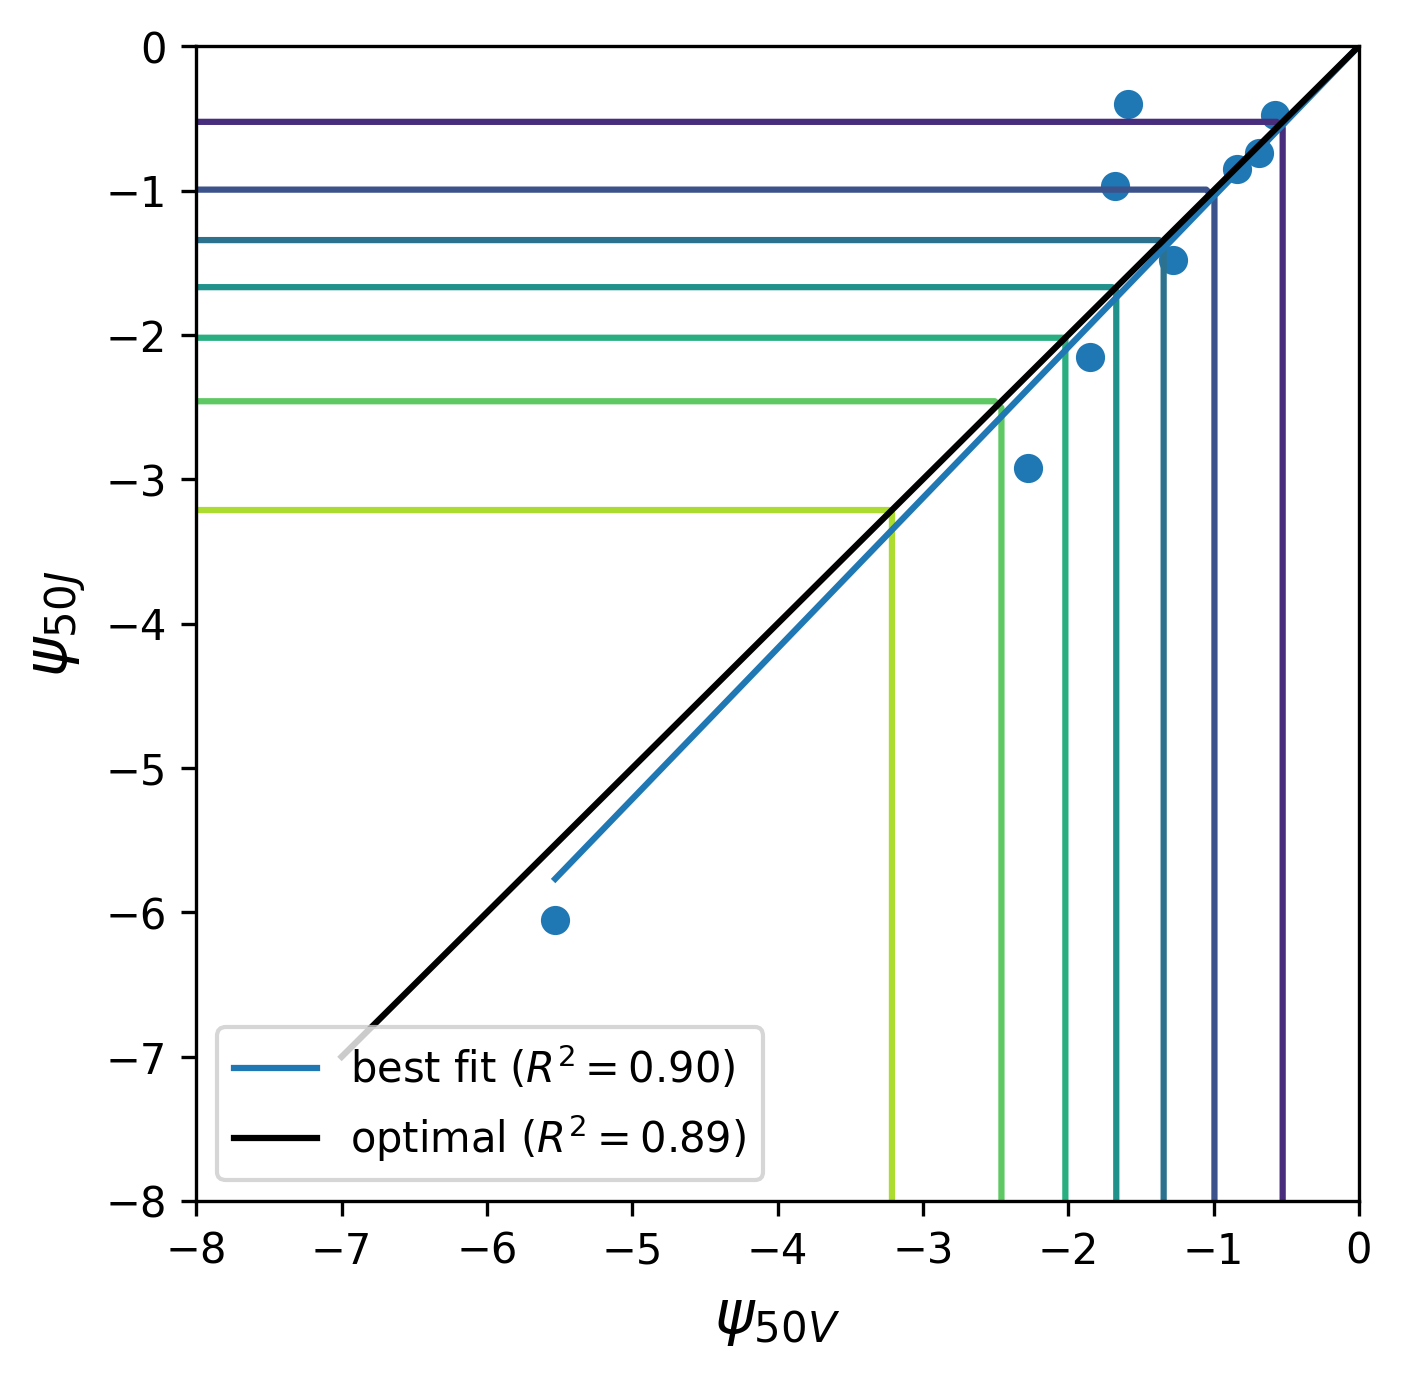

In [43]:

fig, ax = plt.subplots(figsize=(5,5),dpi=300)
X1,Y1 = np.meshgrid(x,x)
#levels = [0.05,0.1,0.15,0.2,0.25,0.3,0.51]
ax.contour(-X1,-Y1,A_mins_2D)

psi50V = -1* np.array([5.53, 2.28, 1.28, 1.85, 1.59, 1.68, 0.84, 0.58, 0.69])
psi50J = -1* np.array([6.05, 2.92, 1.48, 2.15, 0.4, 0.97, 0.85, 0.48, 0.74])
ax.scatter(psi50V,psi50J)
ax.set_ylim(top=0)
temp = np.linspace(-7,0,10)
ax.plot(x8, psi50J_pred, color='tab:blue', alpha=1,linestyle='-',label='best fit ('+r'$R^2=0.90$)')
ax.plot(temp,temp,color='k',linestyle='-',alpha=1,label='optimal (' +r'$R^2=0.89$)')

ax.legend(loc='lower left')
ax.set_xlabel(r'$\psi_{50V}$',fontsize='x-large')
ax.set_ylabel(r'$\psi_{50J}$',fontsize='x-large')

plt.show()

In [34]:
psis1 = 1
psis2 = 2

psi50k1 = 2
k1 = 2
# psiLopt(psis1,psi50k1,k1)

# gs2(psiLopt(psis1,psi50k1,k1),psis1,psi50k1,k1)
psi50s = np.linspace(psis1+0.1, 8, 100)
psi50s = np.linspace(0, 8, 100)


gshmaxs = [gs2(psiLopt(psis1, psi50s[i], k1), psis1, psi50s[i], k1)
           for i in range(len(psi50s))]
gshmaxs2 = [gs2(psiLopt(psis2, psi50s[i], k1), psis2, psi50s[i], k1)
            for i in range(len(psi50s))]

Amaxs = [gshmaxs[i]/(gshmaxs[i]+1) for i in range(len(gshmaxs))]
Amaxs2 = [gshmaxs2[i]/(gshmaxs2[i]+1) for i in range(len(gshmaxs))]

NameError: name 'gs2' is not defined

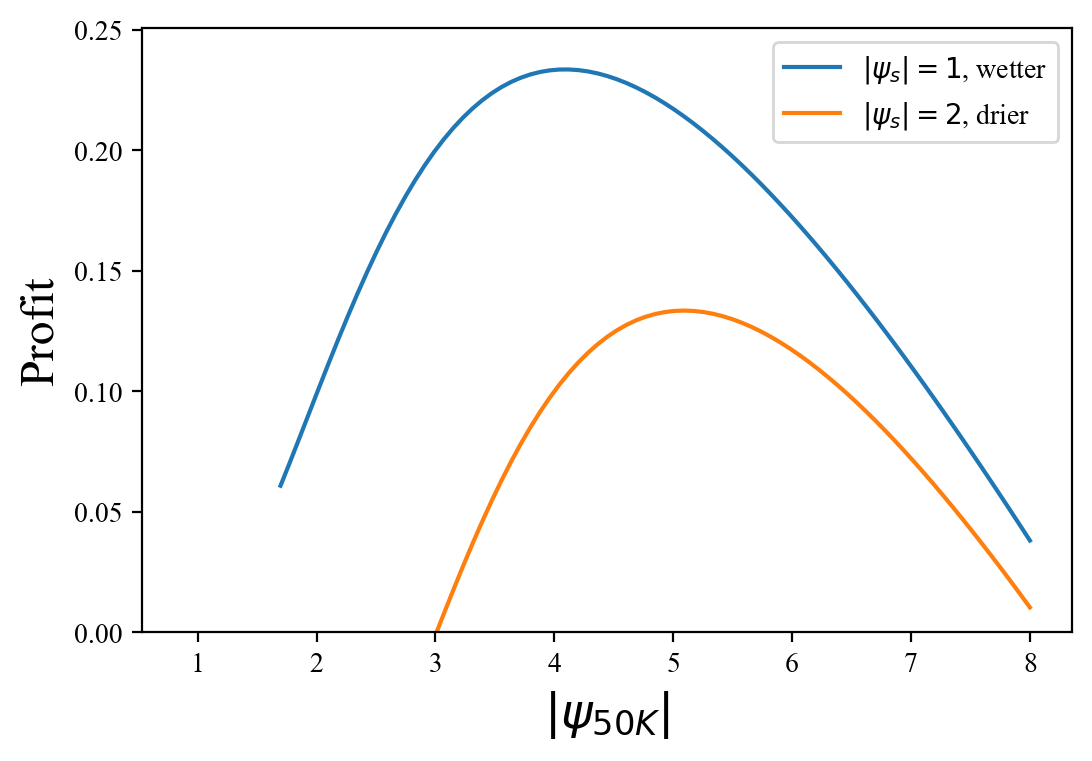

In [ ]:
fig, (ax) = plt.subplots(1, dpi=200)
# ax.plot(psi50s,(gshmaxs))
# ax.plot(psi50s,(gshmaxs2))
# ax.plot(psi50s,(gshmaxs)-0.01*np.exp(psi50s))
# ax.plot(psi50s,(gshmaxs2)-0.01*np.exp(psi50s))
ax.plot(psi50s, Amaxs-psi50s/10, label=r'$|\psi_s|=1$, wetter')
ax.plot(psi50s, Amaxs2-psi50s/10, label=r'$|\psi_s|=2$, drier')
ax.set_xlabel(r'$|\psi_{50K}|$', size='xx-large')
ax.set_ylabel("Profit", size='xx-large')
# ax.set_ylabel(r'$\overline{A}-\alpha_1 |\psi_{50K}|$')
ax.legend()
ax.set_ylim(bottom=0)


plt.show()

# Hydraulic Plotting cells

In [ ]:
def help_plot_gs_psil(psis, psi50, k):
    n = 100
    psi = np.linspace(psis, 5, n)
    g_psi = [g(i, psis, psi50, k) for i in psi]
    return [psi, g_psi]


def plot_gs_psil(psi, psis_list, g_psi_list, psi50_list, sideways=False):
    n_psi = len(psis_list)

    fig = plt.figure(dpi=150)
    ax = fig.add_axes([0, 0, 1, 1])

    colors = ['green', 'blue', 'orange', 'red']

    for i in range(n_psi):
        max_gpsi = max(g_psi_list[i])
        max_psi = psi[np.argmax(g_psi_list[i])]

        count = sum(psi < max_psi)
        psi_low = psi[:count]
        gpsi_low = g_psi_list[i][:count]

        psi_high = psi[count:]
        gpsi_high = g_psi_list[i][count:]
        if not sideways:
            ax.plot(psi_low, gpsi_low, label=r'$|\psi_s|=$'+str(
                psis_list[i]) + ', ' + r'$|\psi_{50K}|=$'+str(psi50_list[i]), color=colors[i])

            ax.plot(psi_high, gpsi_high, linestyle='--', color=colors[i])

            ax.scatter(max_psi, max_gpsi, color='black')

            ax.text(max_psi+0.1, max_gpsi, r'$g_{max}^h$', fontsize='x-large')
            ax.set_ylabel(r'$g_s$', fontsize='xx-large')
            ax.set_xlabel(r'$|\psi_l|$', fontsize='xx-large')
        else:
            ax.plot(gpsi_low, psi_low, label=r'$|\psi_s|=$'+str(
                psis_list[i]) + ', ' + r'$|\psi_{50K}|=$'+str(psi50_list[i]), color=colors[i])

            ax.plot(gpsi_high, psi_high, linestyle='--', color=colors[i])

            ax.scatter(max_gpsi, max_psi, color='black')

            ax.text(max_gpsi, max_psi+0.1, r'$g_{max}^h$', fontsize='x-large')
            color_i = 'red'

            ax.set_xlabel(r'$g_s$', fontsize='xx-large')
            ax.set_ylabel(r'$|\psi_l|$', fontsize='xx-large')

    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)

    ax.legend()

    plt.show()

In [ ]:
psis_list = [0, 0, 2, 2]
psi50_list = [4, 2, 4, 2]
list_1 = help_plot_gs_psil(psis_list[0], psi50_list[0], 1)
list_2 = help_plot_gs_psil(psis_list[1], psi50_list[1], 1)
list_3 = help_plot_gs_psil(psis_list[2], psi50_list[2], 1)
list_4 = help_plot_gs_psil(psis_list[3], psi50_list[3], 1)
max_gpsi = max(list_1[1])
g_psi_list = [list_1[1]/max_gpsi, list_2[1] /
              max_gpsi, list_3[1]/max_gpsi, list_4[1]/max_gpsi]

#plot_gs_psil(list_1[0], psis_list, g_psi_list, psi50_list, sideways=False)

NameError: name 'gs2' is not defined

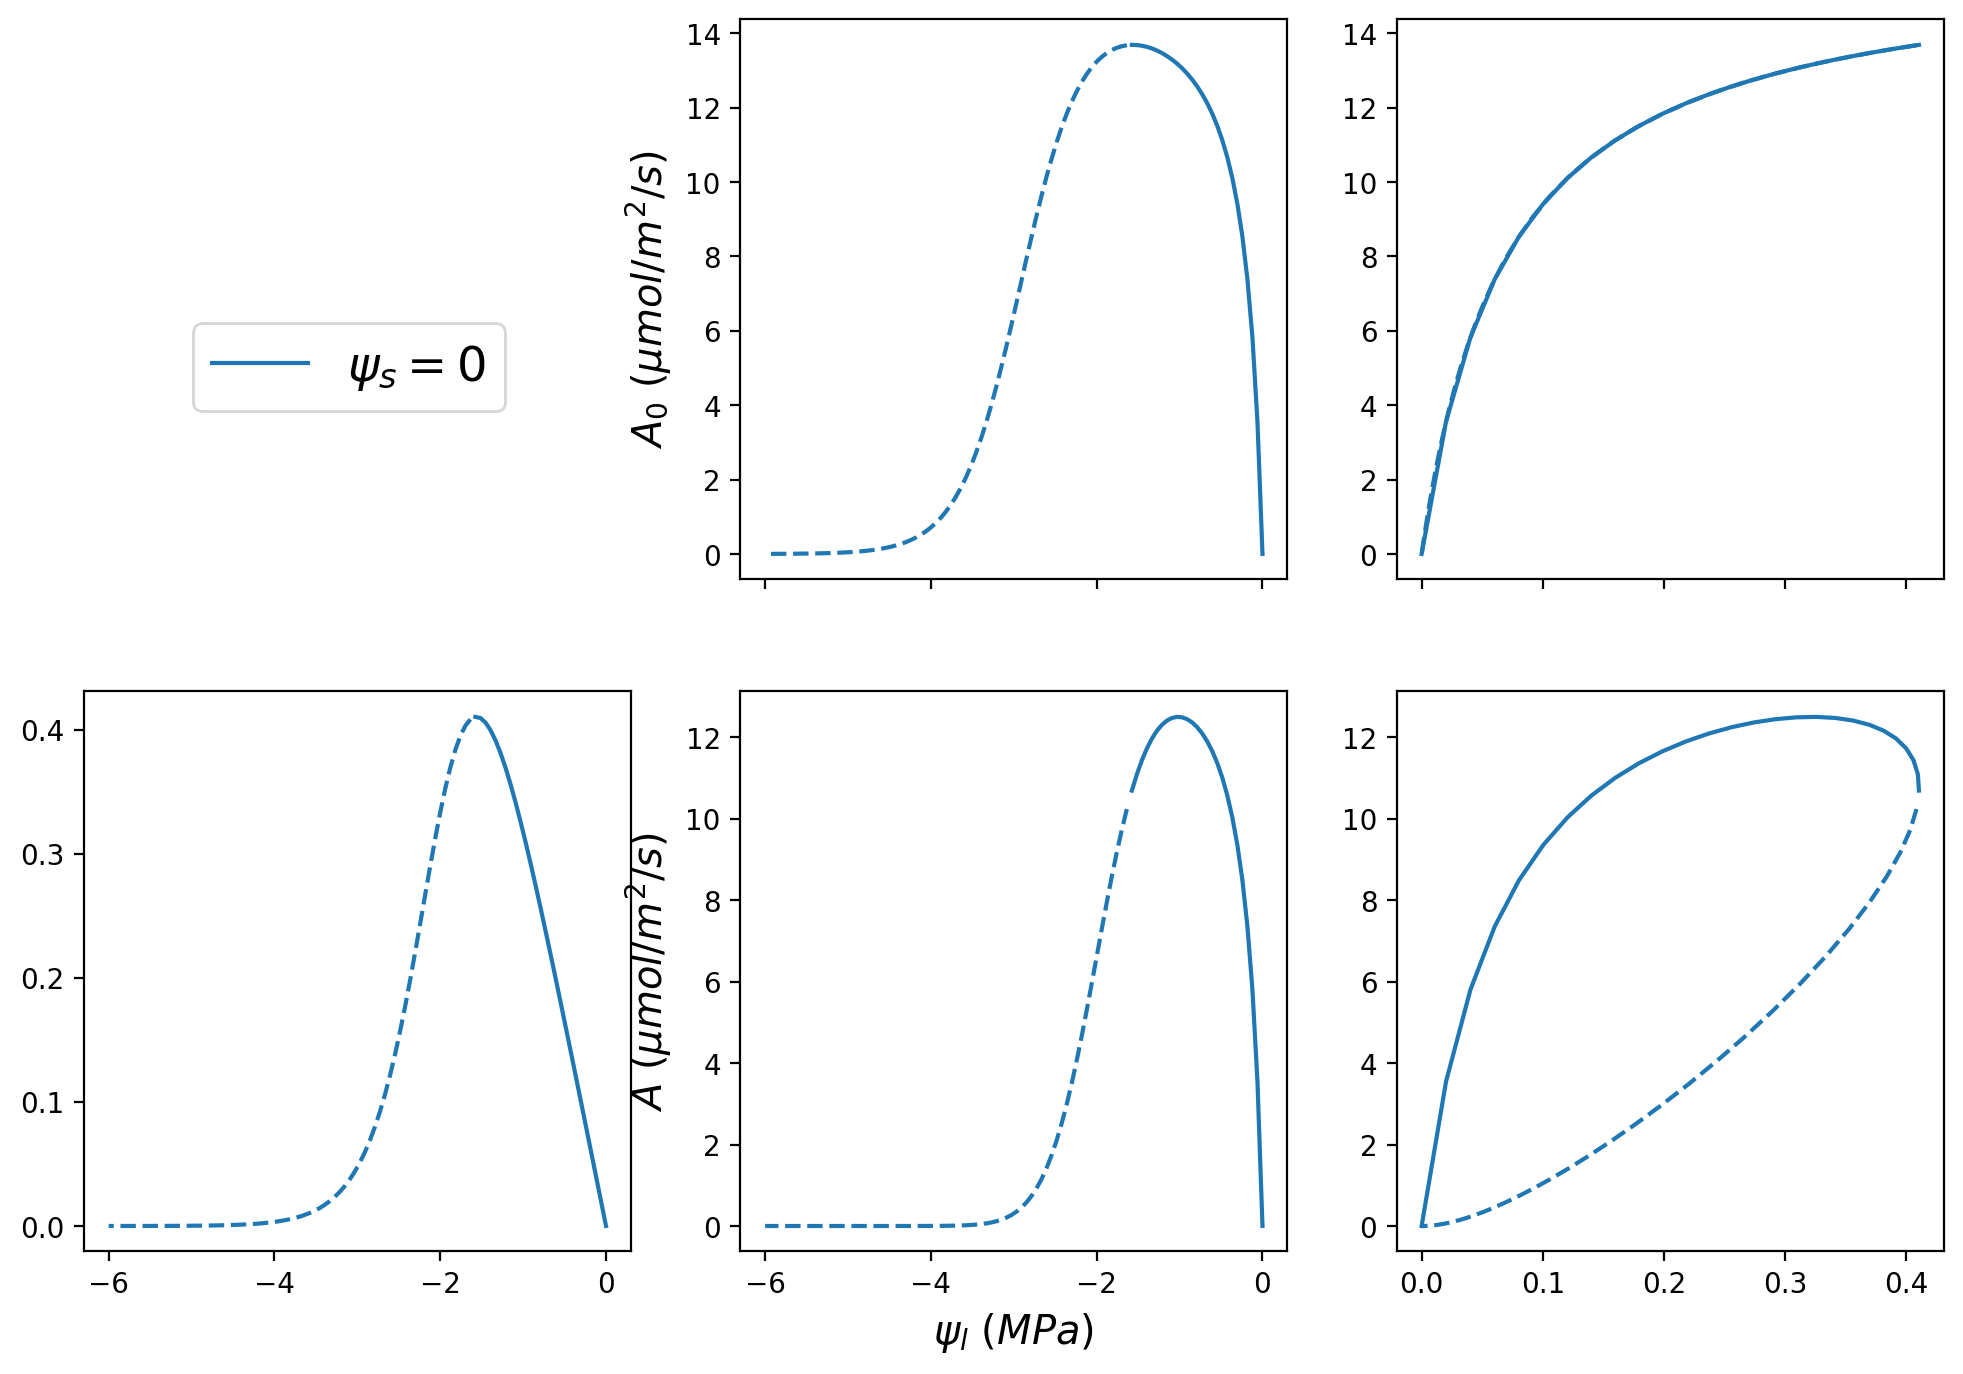

In [ ]:
psi = np.linspace(0,6,100)

def gs(psi, psis, psi50k, Kk):
    if psi <= psis:
        return 0
    return Kmax/D * logistic(psi, psi50k, Kk) * (psi-psis)

psi_label = str(r'$\psi_l$' + " " + r"$(MPa)$")
gs_label = str(r'$g_s$' + " " + r'$(mol/m^2/s)$')
A_label = str(r'$A$' + " " + r'$(\mu mol/m^2/s)$')
A0_label = str(r'$A_0$' + " " + r'$(\mu mol/m^2/s)$')

gs_arr = np.array([gs(psi[i],0,2,3) for i in range(len(psi))])
A_noNSL_arr = np.array([A_NSL(psi[i],0,2,100,3) for i in range(len(psi))])
A_NSL_arr = np.array([A_NSL(psi[i],0,2,2,3) for i in range(len(psi))])


psi_crit = psi[np.argmax(gs_arr)]

psi_low = psi[psi <= psi_crit]
psi_high = psi[psi > psi_crit]
gs_low = gs_arr[psi <= psi_crit]
gs_high = gs_arr[psi > psi_crit]
A_noNSL_low = A_noNSL_arr[psi <= psi_crit]
A_noNSL_high = A_noNSL_arr[psi > psi_crit]
A_NSL_low = A_NSL_arr[psi <= psi_crit]
A_NSL_high = A_NSL_arr[psi > psi_crit]


fig, ax = plt.subplots(2, 3,figsize=(12,8),sharex='col',dpi=200)

# First box, psi vs gs
ax[1,0].plot(-psi_low, gs_low,label=r'$\psi_s = 0$')
ax[1,0].plot(-psi_high, gs_high, color='tab:blue',linestyle='--')


# Second column, psi v A
ax[0,1].plot(-psi_low, A_noNSL_low)
ax[0,1].plot(-psi_high, A_noNSL_high,color='tab:blue',linestyle='--')

ax[1,1].plot(-psi_low, A_NSL_low)
ax[1,1].plot(-psi_high, A_NSL_high,color='tab:blue',linestyle='--')


# Third column, gs v A
ax[0,2].plot(gs_low, A_noNSL_low)
ax[0,2].plot(gs_high, A_noNSL_high,color='tab:blue',linestyle='--')

ax[1,2].plot(gs_low, A_NSL_low)
ax[1,2].plot(gs_high, A_NSL_high,color='tab:blue',linestyle='--')

########################################### 

gs_arr = np.array([gs(psi[i],1,2,3) for i in range(len(psi))])
A_noNSL_arr = np.array([A_NSL(psi[i],1,2,100,3) for i in range(len(psi))])
A_NSL_arr = np.array([A_NSL(psi[i],1,2,2,3) for i in range(len(psi))])


psi_crit = psi[np.argmax(gs_arr)]

psi_low = psi[psi <= psi_crit]
psi_high = psi[psi > psi_crit]
gs_low = gs_arr[psi <= psi_crit]
gs_high = gs_arr[psi > psi_crit]
A_noNSL_low = A_noNSL_arr[psi <= psi_crit]
A_noNSL_high = A_noNSL_arr[psi > psi_crit]
A_NSL_low = A_NSL_arr[psi <= psi_crit]
A_NSL_high = A_NSL_arr[psi > psi_crit]


#fig, ax = plt.subplots(2, 3)

# # First box, psi vs gs
# ax[1,0].plot(-psi_low, gs_low, label=r'$\psi_s = -1$')
# ax[1,0].plot(-psi_high, gs_high,color='tab:orange',linestyle='--')
# ax[1,0].set_ylabel(gs_label,fontdict={'fontsize':'x-large'})
# ax[1,0].set_xlabel(psi_label,fontdict={'fontsize':'x-large'})

# Second column, psi v A
# ax[0,1].plot(-psi_low, A_noNSL_low)
# ax[0,1].plot(-psi_high, A_noNSL_high,color='tab:orange',linestyle='--')
ax[0,1].set_ylabel(A0_label,fontdict={'fontsize':'x-large'})


# ax[1,1].plot(-psi_low, A_NSL_low)
# ax[1,1].plot(-psi_high, A_NSL_high,color='tab:orange',linestyle='--')
ax[1,1].set_ylabel(A_label,fontdict={'fontsize':'x-large'})
ax[1,1].set_xlabel(psi_label,fontdict={'fontsize':'x-large'})

# # Third column, gs v A
# ax[0,2].plot(gs_low, A_noNSL_low)
# ax[0,2].plot(gs_high, A_noNSL_high,color='tab:orange',linestyle='--')
# ax[0,2].set_ylabel(A0_label,fontdict={'fontsize':'x-large'})

# ax[1,2].plot(gs_low, A_NSL_low)
# ax[1,2].plot(gs_high, A_NSL_high,color='tab:orange',linestyle='--')
# ax[1,2].set_ylabel(A_label,fontdict={'fontsize':'x-large'})
# ax[1,2].set_xlabel(gs_label,fontdict={'fontsize':'x-large'})

ax[0, 0].axis('off')

ax[1,0].legend(loc=(0.2,1.5),fontsize='xx-large')
fig.tight_layout=True

plt.show()


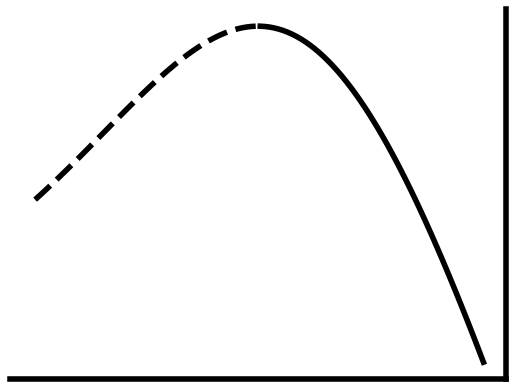

In [ ]:
# gs vs psil
fig, ax = plt.subplots()

X = np.linspace(0,-4,100)
Y = np.array([gs(-i, 0, 2, 1) for i in X])

argmax = np.argmax(Y)
X_low = X[:argmax]
X_high = X[argmax:]
Y_low = Y[:argmax]
Y_high = Y[argmax:]

ax.plot(X_low,Y_low, color='black', linewidth='4')
ax.plot(X_high,Y_high, color='black', linewidth='4',linestyle='--')

ax.set_xticks([])
ax.set_yticks([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)

plt.rc('axes.spines', **{'bottom':True, 'left':False, 'right':True, 'top':False})

plt.show()

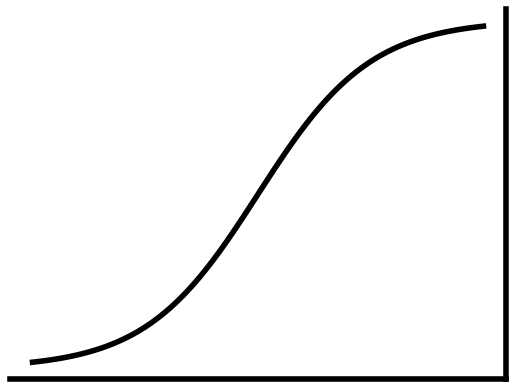

In [ ]:
# k vs psil

fig, ax = plt.subplots()

X = np.linspace(0,-4,100)
Y = np.array([logistic(-i, 2, 2) for i in X])


ax.plot(X,Y,color='black',linewidth=4)


ax.set_xticks([])
ax.set_yticks([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)

plt.rc('axes.spines', **{'bottom':True, 'left':False, 'right':True, 'top':False})


plt.show()

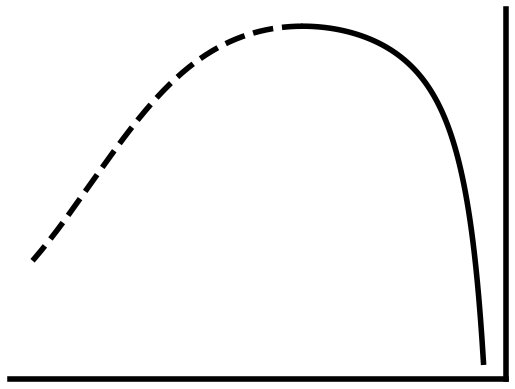

In [ ]:
fig, ax = plt.subplots()

X = np.linspace(0,-4,300)
Y = np.array([A_NSL(-i, 0, 2, 40, 2) for i in X])

argmax = np.argmax(Y)
X_low = X[:argmax]
X_high = X[argmax:]
Y_low = Y[:argmax]
Y_high = Y[argmax:]

ax.plot(X_low,Y_low, color='black', linewidth='4')
ax.plot(X_high,Y_high, color='black', linewidth='4',linestyle='--')
# ax.plot(X,Y,linewidth=2)

ax.set_xticks([])
ax.set_yticks([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)

plt.rc('axes.spines', **{'bottom':True, 'left':False, 'right':True, 'top':False})


plt.show()

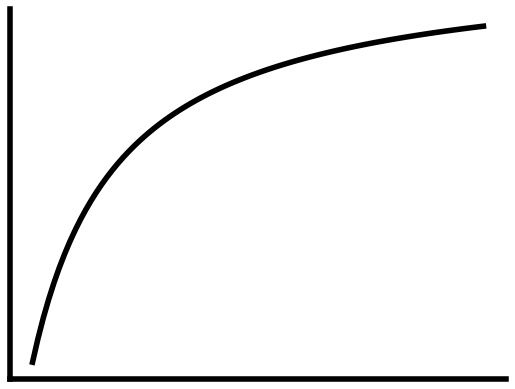

In [ ]:
fig, ax = plt.subplots()

X = np.linspace(0,-4,300)
G = np.array([gs(-i, 0, 2, 2) for i in X])
Y = np.array([A_NSL(-i, 0, 2, 2, 2) for i in X])
Y2 = np.array([A_NSL(-i, 0, 2, 50, 2) for i in X])


argmax = np.argmax(G)
X_low = X[:argmax]
X_high = X[argmax:]
G_low = G[:argmax]
G_high = G[argmax:]
Y_low = Y[:argmax]
Y_high = Y[argmax:]

Y2_low = Y2[:argmax]
Y2_high = Y2[argmax:]

# ax.plot(G_low,Y_low, color='tab:orange', linewidth='2')
# ax.plot(G_high,Y_high, color='tab:orange', linewidth='2',linestyle='--')

ax.plot(G_low,Y2_low, color='black', linewidth='4')
# ax.plot(G_high,Y2_high, color='brown', linewidth='2',linestyle='--')
# ax.plot(X,Y,linewidth=2)


ax.set_xticks([])
ax.set_yticks([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)

plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})


plt.show()

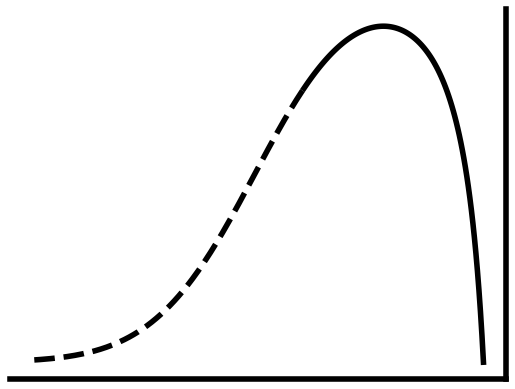

In [ ]:
fig, ax = plt.subplots()

X = np.linspace(0,-4,300)
G = np.array([gs(-i, 0, 2, 2) for i in X])
Y = np.array([A_NSL(-i, 0, 2, 2, 2) for i in X])
Y2 = np.array([A_NSL(-i, 0, 2, 50, 2) for i in X])


argmax = np.argmax(G)
X_low = X[:argmax]
X_high = X[argmax:]
G_low = G[:argmax]
G_high = G[argmax:]
Y_low = Y[:argmax]
Y_high = Y[argmax:]

Y2_low = Y2[:argmax]
Y2_high = Y2[argmax:]

ax.plot(X_low,Y_low, color='black', linewidth='4')
ax.plot(X_high,Y_high, color='black', linewidth='4',linestyle='--')

# ax.plot(G_low,Y2_low, color='black', linewidth='2')
# ax.plot(G_high,Y2_high, color='brown', linewidth='2',linestyle='--')
# ax.plot(X,Y,linewidth=2)


ax.set_xticks([])
ax.set_yticks([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)

plt.rc('axes.spines', **{'bottom':True, 'left':False, 'right':True, 'top':False})


plt.show()

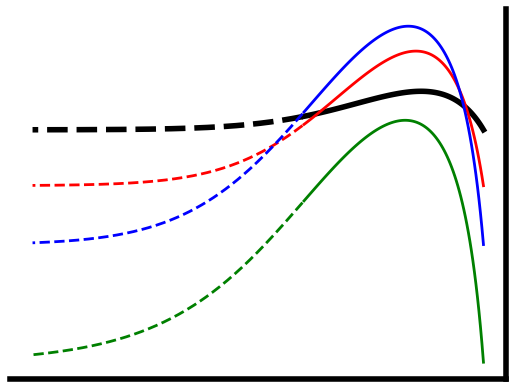

In [ ]:
fig, ax = plt.subplots()
fact=2
X = np.linspace(-1,-4,300)
Y = np.array([A_NSL(-i, 1, 0.05, 2, 2)-fact*0.05 for i in X])
Y2 = np.array([A_NSL(-i, 1, 1, 2, 2)-fact*1 for i in X])
Y3 = np.array([A_NSL(-i, 1, 2, 2, 2)-fact*2 for i in X])
Y4 = np.array([A_NSL(-i, 1, 4, 2, 2)-fact*4 for i in X])


argmax = np.argmax(G)
X_low = X[:argmax]
X_high = X[argmax:]

Y_low = Y[:argmax]
Y_high = Y[argmax:]

Y2_low = Y2[:argmax]
Y2_high = Y2[argmax:]

Y3_low = Y3[:argmax]
Y3_high = Y3[argmax:]

Y4_low = Y4[:argmax]
Y4_high = Y4[argmax:]


ax.plot(X_low,Y_low, color='black', linewidth='4')
ax.plot(X_high,Y_high, color='black', linewidth='4',linestyle='--')

ax.plot(X_low,Y2_low, color='red', linewidth='2')
ax.plot(X_high,Y2_high, color='red', linewidth='2',linestyle='--')
# ax.plot(X,Y,linewidth=2)


ax.plot(X_low,Y3_low, color='blue', linewidth='2')
ax.plot(X_high,Y3_high, color='blue', linewidth='2',linestyle='--')

ax.plot(X_low,Y4_low, color='green', linewidth='2')
ax.plot(X_high,Y4_high, color='green', linewidth='2',linestyle='--')


ax.set_xticks([])
ax.set_yticks([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)

plt.rc('axes.spines', **{'bottom':True, 'left':False, 'right':True, 'top':False})


plt.show()

In [ ]:
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=3,nrows=2,figure=fig)
f_ax1 = fig.add_subplot(spec[0, 0])
f_ax2 = fig.add_subplot(spec[0, 1])
f_ax3 = fig.add_subplot(spec[0, 2])
f_ax4 = fig.add_subplot(spec[1, 1])
f_ax5 = fig.add_subplot(spec[1, 2])

# Wet
psi_wet, g_psi_wet = help_plot_gs_psil(psis=0, psi50=2, k=2)
psi_max_index_wet = np.argmax(g_psi_wet)

psi_low_wet = psi_wet[:psi_max_index_wet]
psi_high_wet = psi_wet[psi_max_index_wet:]
g_psi_low_wet = g_psi_wet[:psi_max_index_wet]
g_psi_high_wet = g_psi_wet[psi_max_index_wet:]

A_psi_wet = A2(psi_wet, 0, psi50A=100, psi50K=2, kA=2, kK=2)
A_psi_low_wet = A_psi_wet[:psi_max_index_wet]

A_psi_wet_NSL = A2(psi_wet, 0, psi50A=1.5, psi50K=2, kA=2, kK=2)
A_psi_low_wet_NSL = A_psi_wet_NSL[:psi_max_index_wet]

# Dry
psi_dry, g_psi_dry = help_plot_gs_psil(psis=1, psi50=2, k=2)
psi_max_index_dry = np.argmax(g_psi_dry)

psi_low_dry = psi_dry[:psi_max_index_dry]
g_psi_low_dry = g_psi_dry[:psi_max_index_dry]
psi_high_dry = psi_dry[psi_max_index_dry:]
g_psi_high_dry = g_psi_dry[psi_max_index_dry:]


A_psi_dry = A2(psi_dry, 1, psi50A=100, psi50K=2, kA=2, kK=2)
A_psi_low_dry = A_psi_dry[:psi_max_index_dry]

A_psi_dry_NSL = A2(psi_dry, 1, psi50A=1.5, psi50K=2, kA=2, kK=2)
A_psi_low_dry_NSL = A_psi_dry_NSL[:psi_max_index_dry]

# [0, 0] gs vs. psil
f_ax1.plot(psi_low_wet, g_psi_low_wet)
f_ax1.plot(psi_low_dry, g_psi_low_dry)
f_ax1.hlines(y = g_psi_high_wet[0],xmin = psi_high_wet[0],xmax=psi_high_wet[-1], linestyle='--',color='tab:blue',alpha=0.5)
f_ax1.hlines(y = g_psi_high_dry[0], xmin=psi_high_dry[0],xmax=psi_high_dry[-1],linestyle='--',color='tab:orange',alpha=0.5)

f_ax1.text(3,0.8,r'$g_{crit}$')

f_ax1.set_ylabel(r'$g_s/g_{max}$')
f_ax1.set_yticks([])
f_ax1.set_xlabel(r'$\psi_l (-MPa)$')
f_ax1.set_xticks([])


# [0, 1] A vs. psil
f_ax2.plot(psi_low_wet, A_psi_low_wet)
f_ax2.plot(psi_low_dry, A_psi_low_dry)
f_ax2.set_ylabel(r'$A_0/A_{max}$')
f_ax2.set_xticks([])
f_ax2.set_yticks([])

# [0, 2] A vs. gs no NSL
f_ax3.plot(g_psi_low_wet,A_psi_low_wet)
f_ax3.plot(g_psi_low_dry,A_psi_low_dry)
f_ax3.vlines(x=g_psi_high_wet[0],ymin=A_psi_low_wet_NSL[0],ymax=A_psi_low_wet[-1],linestyle='--',color='tab:blue',alpha=0.5)
f_ax3.vlines(x=g_psi_high_dry[0],ymin=A_psi_low_dry_NSL[0],ymax=A_psi_low_dry[-1],linestyle='--',color='tab:orange',alpha=0.5)
f_ax3.text(0.65,0.1,r'$g_{crit}$')
f_ax3.set_ylabel(r'$A_0/A_{max}$')
f_ax3.set_xticks([])
f_ax3.set_yticks([])

# [1, 1] A vs. psil
f_ax4.plot(psi_low_wet, A_psi_low_wet_NSL)
f_ax4.plot(psi_low_dry, A_psi_low_dry_NSL)
f_ax4.set_ylabel(r'$A/A_{max}$')
f_ax4.set_xlabel(r'$\psi_l$ (-MPa)')
wet_NSL_argmax = np.argmax(A_psi_low_wet_NSL)
psi_star_wet = psi_low_wet[wet_NSL_argmax]
dry_NSL_argmax = np.argmax(A_psi_low_dry_NSL)
psi_star_dry = psi_low_dry[dry_NSL_argmax]
f_ax4.scatter(psi_star_wet,max(A_psi_low_wet_NSL),marker='*')
f_ax4.scatter(psi_star_dry,max(A_psi_low_dry_NSL),marker='*')

f_ax4.text(1,0.2,r'$\psi_l^*$')
#f_ax4.set_xticks([psi_star_wet,psi_star_dry])
#f_ax4.set_xticklabels([r'$\psi^*$',r'$\psi^*$'])
f_ax4.set_yticks([])
f_ax4.set_xticks([])


# [1, 2] A vs. gs no NSL
f_ax5.plot(g_psi_low_wet,A_psi_low_wet_NSL,label='Wet Soil')
f_ax5.plot(g_psi_low_dry,A_psi_low_dry_NSL,label = 'Dry Soil')
f_ax5.set_ylabel(r'$A/A_{max}$')
f_ax5.set_xlabel(r'$g_s/g_{max}$')
f_ax5.vlines(x=g_psi_high_wet[0],ymin=A_psi_low_wet_NSL[0],ymax=A_psi_low_wet_NSL[-1],linestyle='--',color='tab:blue',alpha=0.5)
f_ax5.vlines(x=g_psi_high_dry[0],ymin=A_psi_low_dry_NSL[0],ymax=A_psi_low_dry_NSL[-1],linestyle='--',color='tab:orange',alpha=0.5)
f_ax5.set_xticks([])
f_ax5.scatter(g_psi_low_wet[wet_NSL_argmax],max(A_psi_low_wet_NSL),marker='*')
f_ax5.scatter(g_psi_low_dry[dry_NSL_argmax],max(A_psi_low_dry_NSL),marker='*')
f_ax5.text(0.5,0.2,r'$g_s^*$')
f_ax5.text(0.65,0.01,r'$g_{crit}$')

f_ax5.set_yticks([])

fig.legend(loc=(0.05,0.2))

plt.show()

NameError: name 'gridspec' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
np.argmax(A_psi_low_dry_NSL)

13

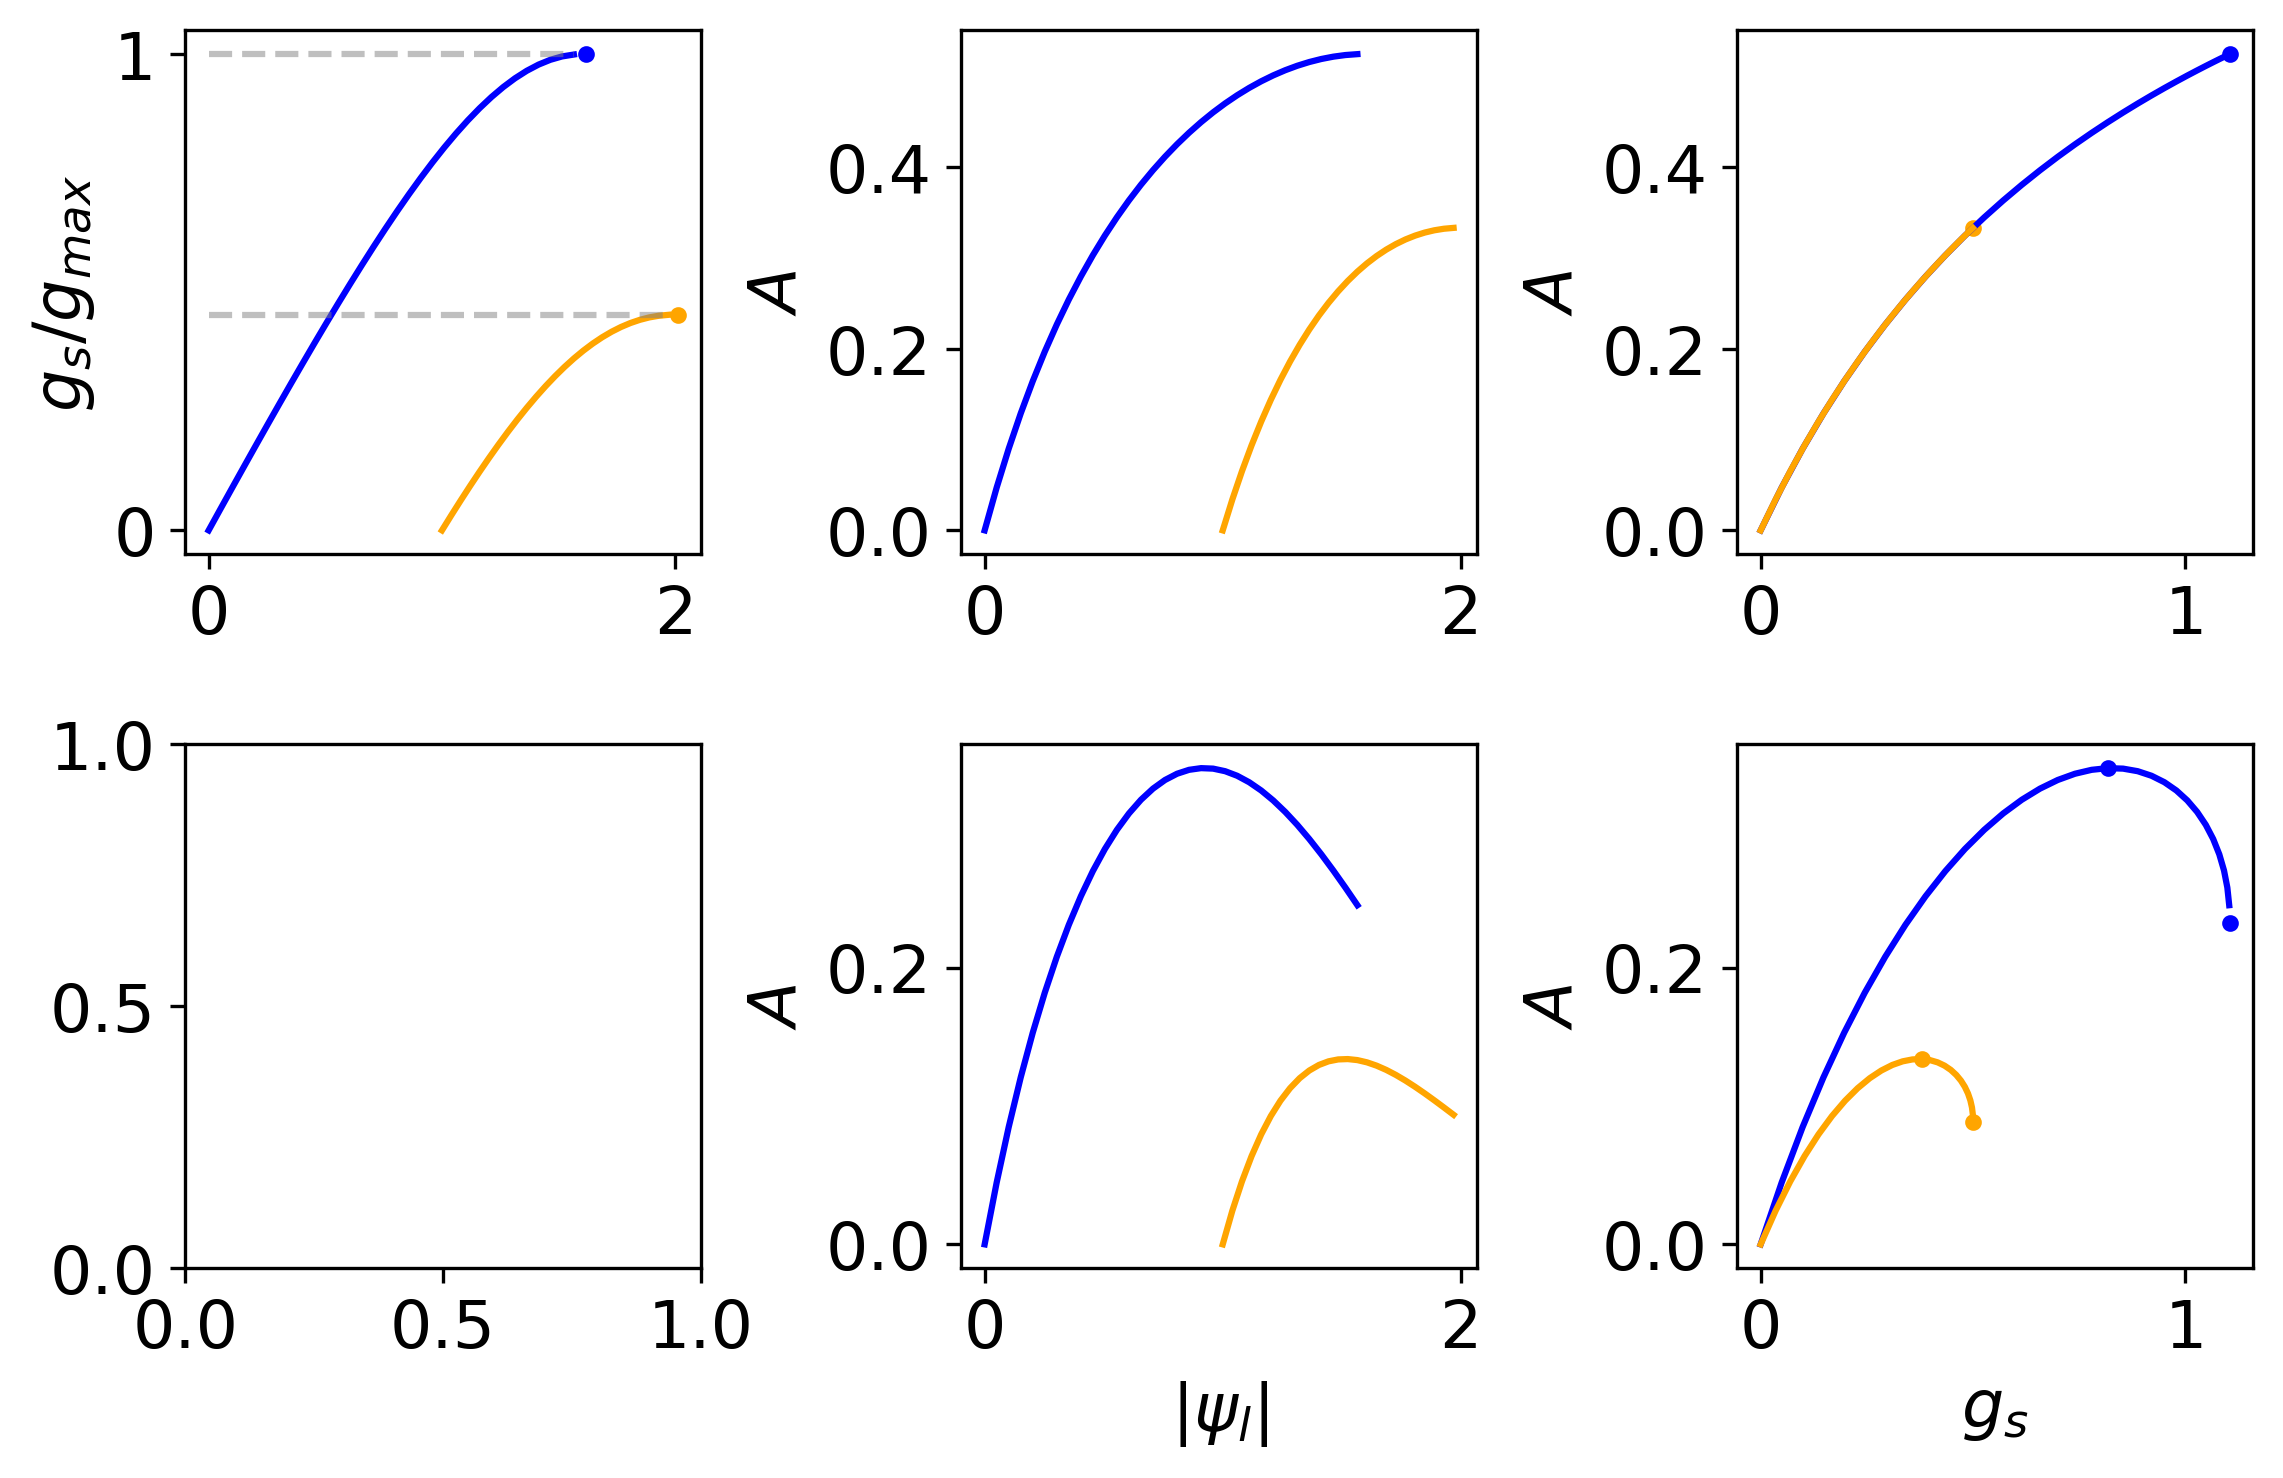

In [ ]:

fig, ax = plt.subplots(2, 3, figsize=(8, 5), dpi=300)
fig.tight_layout()
# 0: gs vs psil
psis_temp = 0
alpha_d = 0.3
colors = ['blue', 'orange']
labels = [str(r'$|\psi_s| = 0$'), str(r'$|\psi_s| = 1$')]

round1 = True

for i in range(2):
    psi, g_psi = help_plot_gs_psil(psis=psis_temp, psi50=2, k=2)
    psi_max_index = np.argmax(g_psi)

    psi_low = psi[:psi_max_index]
    psi_high = psi[psi_max_index:]
    g_psi_low = g_psi[:psi_max_index]
    g_psi_high = g_psi[psi_max_index:]

    ax[0, 0].plot(psi_low, g_psi_low, color=colors[i])
    #ax[0, 0].plot(psi_high, g_psi_high, linestyle='--',
    #              color=colors[i], alpha=alpha_d)
    ax[0, 0].scatter(psi_high[0], g_psi_high[0], color=colors[i], marker='.')
    ax[0, 0].hlines(y=g_psi_high[0],xmin=0,xmax=max(psi_low),color='gray',linestyle='--',alpha=0.5)
    #ax[0, 0].text(psi_high[0]+0.1, g_psi_high[0], r'$g_{max}^h$')

    # ax[0, 0].set_xlabel(r'$|\psi_l|$')
    ax[0, 0].set_ylabel(r'$g_s/g_{max}$')

    A_psi = A2(psi, psis_temp, psi50A=100, psi50K=2, kA=2, kK=2)
    A_psi_low = A_psi[:psi_max_index]
    A_psi_high = A_psi[psi_max_index:]

    ax[0, 1].plot(psi_low, A_psi_low, color=colors[i])
    #ax[0, 1].plot(psi_high, A_psi_high, linestyle='--',
    #              color=colors[i], alpha=alpha_d)
    # ax[0, 1].set_xlabel(r'$|\psi_l|$')
    ax[0, 1].set_ylabel(r'$A$')

    g = np.linspace(0, 1, 100)

    ax[0, 2].plot(g_psi_low, A_psi_low, color=colors[i])
    ax[0, 2].scatter(g_psi_high[0], A_psi_high[0], color=colors[i], marker='.')
    #ax[0, 2].text(g_psi_high[0], A_psi_high[0], r'$g_s^{M}$')
    ax[0, 2].set_ylabel(r'$A$')

    if round1:
            g_psi_high_1_1 = g_psi_high[0]
    psi, g_psi = help_plot_gs_psil(psis=psis_temp, psi50=2, k=2)
    psi_max_index = np.argmax(g_psi)
    psi_low = psi[:psi_max_index]
    psi_high = psi[psi_max_index:]
    g_psi_low = g_psi[:psi_max_index]
    g_psi_high = g_psi[psi_max_index:]

    if round1:
        g_psi_high_1_2 = g_psi_high[0]

    # ax[1, 0].plot(psi_low, g_psi_low, color=colors[i])
    # #ax[1, 0].plot(psi_high, g_psi_high, linestyle='--',
    # #              color=colors[i], alpha=alpha_d)
    # ax[1, 0].scatter(psi_high[0], g_psi_high[0], color=colors[i], marker='.')
    # #ax[1, 0].text(psi_high[0]+0.1, g_psi_high[0], r'$g_{max}^h$')
    # ax[1, 0].hlines(y=g_psi_high[0],xmin=0,xmax=max(psi_low),color='gray',linestyle='--',alpha=0.5)
    # ax[1, 0].set_xlabel(r'$|\psi_l|$')
    # ax[1, 0].set_ylabel(r'$g_s/g_{max}$')

    A_psi = A2(psi, psis_temp, psi50A=1.5, psi50K=2, kA=2, kK=2)
    A_psi_low = A_psi[:psi_max_index]
    A_psi_high = A_psi[psi_max_index:]

    ax[1, 1].plot(psi_low, A_psi_low, color=colors[i], label=labels[i])
    #ax[1, 1].plot(psi_high, A_psi_high, linestyle='--',
    #              color=colors[i], alpha=alpha_d)
    
    ax[1, 1].set_xlabel(r'$|\psi_l|$')
    ax[1, 1].set_ylabel(r'$A$')

    #ax[1, 1].legend()

    g = np.linspace(0, 1, 100)

    ax[1, 2].plot(g_psi_low, A_psi_low, color=colors[i])
    ax[1, 2].scatter(g_psi_high[0], A_psi_high[0], color=colors[i], marker='.')
    #ax[1, 2].text(g_psi_high[0], A_psi_high[0], r'$g_{s}^{max}$')
    ax[1, 2].set_xlabel(r'$g_s$')
    ax[1, 2].set_ylabel(r'$A$')

    # Get gopt
    arg_opt = np.argmax(A_psi_low)
    ax[1, 2].scatter(g_psi_low[arg_opt], A_psi_low[arg_opt],
                     color=colors[i], marker='.')
    #ax[1, 2].text(g_psi_low[arg_opt]-0.1,
    #              A_psi_low[arg_opt]-0.02, r'$g^*_s$')

    psis_temp = 1
    round1= False


ax[0, 0].set_yticks([0,g_psi_high_1_1])
ax[0, 0].set_yticklabels([0,1])
#ax[1, 0].set_yticks([0,g_psi_high_1_2])
#ax[1, 0].set_yticklabels([0,1])
# ax[1, 0].set_yticks([0,g_psi_high[0]])
# ax[1, 0].set_yticks([0,g_psi_high[0]])
# ax[1, 0].set_yticks([0,g_psi_high[0]])

plt.show()

In [ ]:
g_psi_high_1_2

1.1038676651190535

In [ ]:
def opt_psi(psi_s):
    psi_opts_1 = []
    psi_opts_2 = []
    psi_opts_3 = []

    for i in range(len(psi_s)):
        psis_temp = psi_s[i]
        psi50k = 2
        psi_list, g_list = help_plot_gs_psil(psis_temp, psi50=psi50k, k=2)
        argmax = np.argmax(g_list)

        psi_list = psi_list[:argmax]
        A_list_0 = A2(psi_list, psis_temp, psi50A=100,
                      psi50K=psi50k, kA=1, kK=2)
        A_list_NSL = A2(psi_list, psis_temp, psi50A=2,
                        psi50K=psi50k, kA=1, kK=2)
        A_m_theta = A_list_NSL-psi_list**2/40

        argmax_A1 = np.argmax(A_list_0)
        argmax_A2 = np.argmax(A_list_NSL)
        argmax_A3 = np.argmax(A_m_theta)

        psi_opts_1.append(psi_list[argmax_A1])
        psi_opts_2.append(psi_list[argmax_A2])
        psi_opts_3.append(psi_list[argmax_A3])
    opts_out = [psi_opts_1, psi_opts_2, psi_opts_3]

    return opts_out

In [ ]:
def logistic_list(listy, psi50, k):
    output = []
    for i in range(len(listy)):
        output.append(logistic(listy[i], psi50, k))

    return output

Text(0, 0.5, '$|\\psi_{l,opt}|$')

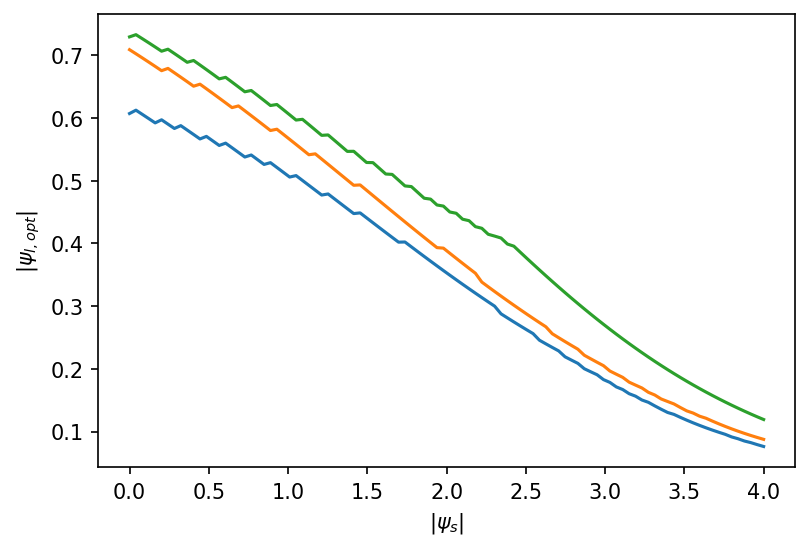

In [ ]:
psis_list = np.linspace(0, 4, 100)

out = opt_psi(psis_list)
fig, ax = plt.subplots()
ax.plot(psis_list, logistic_list(out[0], 2, 1))
ax.plot(psis_list, logistic_list(out[1], 2, 1))
ax.plot(psis_list, logistic_list(out[2], 2, 1))
ax.set_xlabel(r'$|\psi_s|$')
ax.set_ylabel(r'$|\psi_{l,opt}|$')

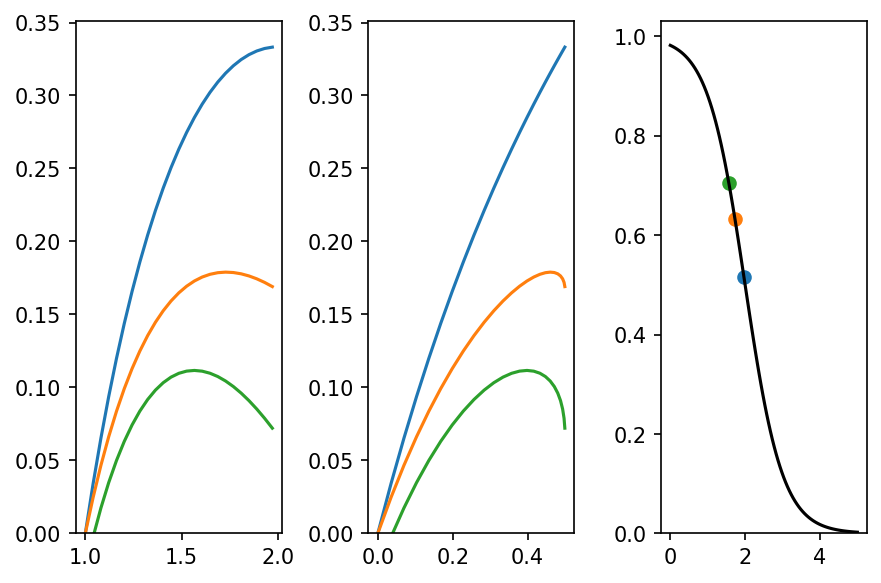

In [ ]:
fig, ax = plt.subplots(1, 3, dpi=150)
fig.tight_layout()
psis_temp = 1
psi50k = 2
psi_list, g_list = help_plot_gs_psil(psis_temp, psi50=psi50k, k=2)
argmax = np.argmax(g_list)

psi_list = psi_list[:argmax]
A_list_0 = A2(psi_list, psis_temp, psi50A=100, psi50K=psi50k, kA=1, kK=2)
A_list_NSL = A2(psi_list, psis_temp, psi50A=2, psi50K=psi50k, kA=1, kK=2)
A_m_theta = A_list_NSL-psi_list**2/40

argmax_A1 = np.argmax(A_list_0)
argmax_A2 = np.argmax(A_list_NSL)
argmax_A3 = np.argmax(A_m_theta)

# Getting max psi values for 1, 2, and 3

ax[0].plot(psi_list, A_list_0)
ax[0].plot(psi_list, A_list_NSL)
ax[0].plot(psi_list, A_m_theta)

ax[1].plot(g_list[:argmax], A_list_0)
ax[1].plot(g_list[:argmax], A_list_NSL)
ax[1].plot(g_list[:argmax], A_m_theta)


x = np.linspace(0, 5, 100)
ax[2].plot(x, logistic(x, psi50k, 2), color='black')
ax[2].scatter(psi_list[argmax_A1], logistic(psi_list[argmax_A1], psi50k, 2))
ax[2].scatter(psi_list[argmax_A2], logistic(psi_list[argmax_A2], psi50k, 2))
ax[2].scatter(psi_list[argmax_A3], logistic(psi_list[argmax_A3], psi50k, 2))

ax[0].set_ylim(bottom=0)
ax[1].set_ylim(bottom=0)
ax[2].set_ylim(bottom=0)

plt.show()

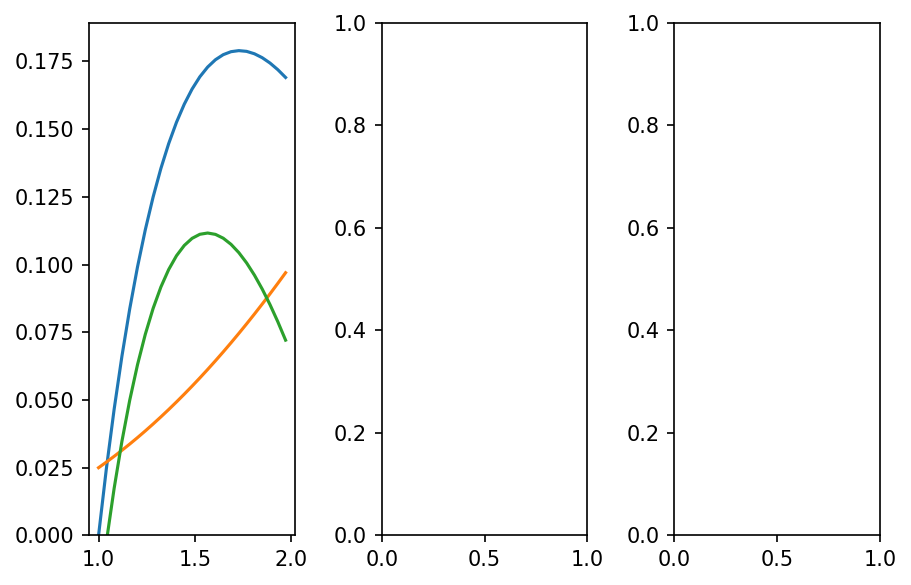

In [ ]:
fig, ax = plt.subplots(1, 3, dpi=150)
fig.tight_layout()
psis_temp = 1
psi50k = 2
psi_list, g_list = help_plot_gs_psil(psis_temp, psi50=psi50k, k=2)
argmax = np.argmax(g_list)

psi_list = psi_list[:argmax]
A_list_0 = A2(psi_list, psis_temp, psi50A=100, psi50K=psi50k, kA=1, kK=2)
A_list_NSL = A2(psi_list, psis_temp, psi50A=2, psi50K=psi50k, kA=1, kK=2)
A_m_theta = A_list_NSL-psi_list**2/40

argmax_A1 = np.argmax(A_list_0)
argmax_A2 = np.argmax(A_list_NSL)
argmax_A3 = np.argmax(A_m_theta)

# Getting max psi values for 1, 2, and 3

ax[0].plot(psi_list, A_list_NSL)
ax[0].plot(psi_list, (psi_list**2)/40)
ax[0].plot(psi_list, A_m_theta)
# ax[0].set_xlim(left=0)
ax[0].set_ylim(bottom=0)

plt.show()

# More Plots Stomata

In [ ]:
# Short v long term
n = 100
x = np.linspace(0,10,n)
def parab(x,x0,y0,a):
    return a*(x-x0)**2 + y0
long_prof = [parab(x[i],5,30,0.5) for i in range(len(x))]



[]

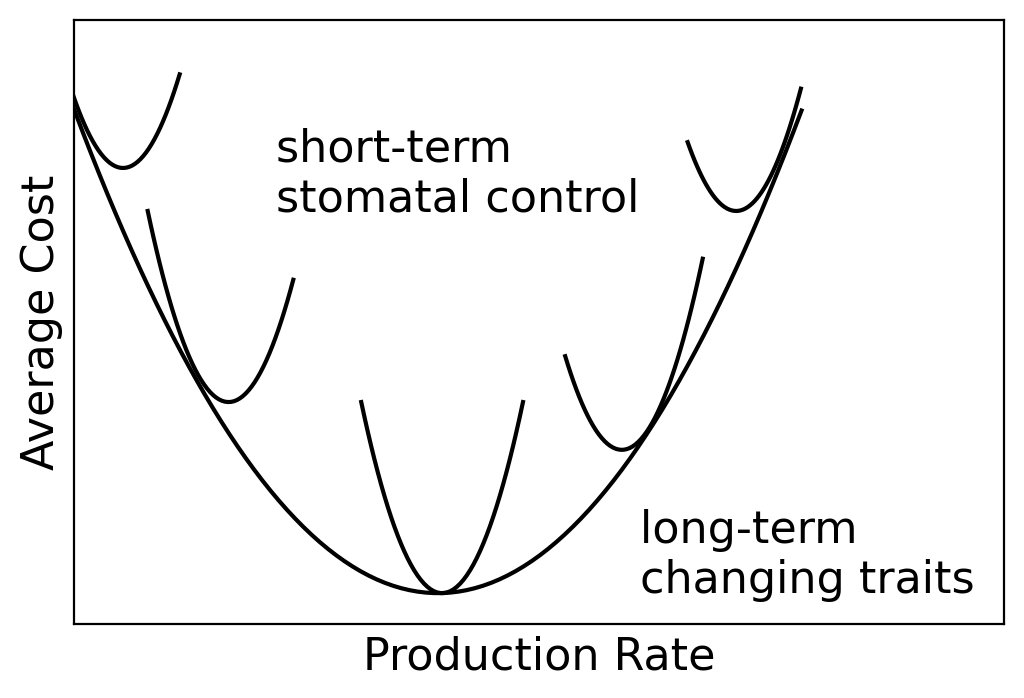

In [ ]:
fig, ax = plt.subplots(dpi=200)
ax.plot(x[0:-5],long_prof[0:-5],color='k')
a_lil = 4

x0_lil = x[5]+0.6
y0_lil = 30 + (30-21.1)
x_lil = np.linspace(x0_lil-1,x0_lil+0.7,50)
ax.plot(x_lil,parab(x_lil,x0_lil,y0_lil,a_lil),color='k')

x0_lil = x[10]+1.4
y0_lil = 30 + (30-26)
x_lil = np.linspace(x0_lil-1,x0_lil+0.8,50)
ax.plot(x_lil,parab(x_lil,x0_lil,y0_lil,a_lil),color='k')

x0_lil = x[50]
y0_lil = 30 
x_lil = np.linspace(x0_lil-1,x0_lil+1,50)
ax.plot(x_lil,parab(x_lil,x0_lil,y0_lil,a_lil),color='k')

x0_lil = x[72]
y0_lil = 27 + 6
x_lil = np.linspace(x0_lil-0.7,x0_lil+1,50)
ax.plot(x_lil,parab(x_lil,x0_lil,y0_lil,a_lil),color='k')

x0_lil = x[86]
y0_lil = 30 + (30-22)
x_lil = np.linspace(x0_lil-0.6,x0_lil+0.8,50)
ax.plot(x_lil,parab(x_lil,x0_lil,y0_lil,a_lil),color='k')

ax.text(3,38,"short-term \nstomatal control")
ax.text(7.5,30,"long-term \nchanging traits")

ax.set_ylabel("Average Cost")

ax.set_xlabel("Production Rate")

ax.set_xlim([0.5,12])
ax.set_ylim(top=42)
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
100%20

0

C:\Users\amatt\AppData\Local\Temp\ipykernel_30524\2397338792.py:27: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(gss,A_arr*(1-Theta_arr/A_arr),label=r'$A_0f(\psi_l)$')
C:\Users\amatt\AppData\Local\Temp\ipykernel_30524\2397338792.py:27: RuntimeWarning: invalid value encountered in multiply
  ax[1].plot(gss,A_arr*(1-Theta_arr/A_arr),label=r'$A_0f(\psi_l)$')


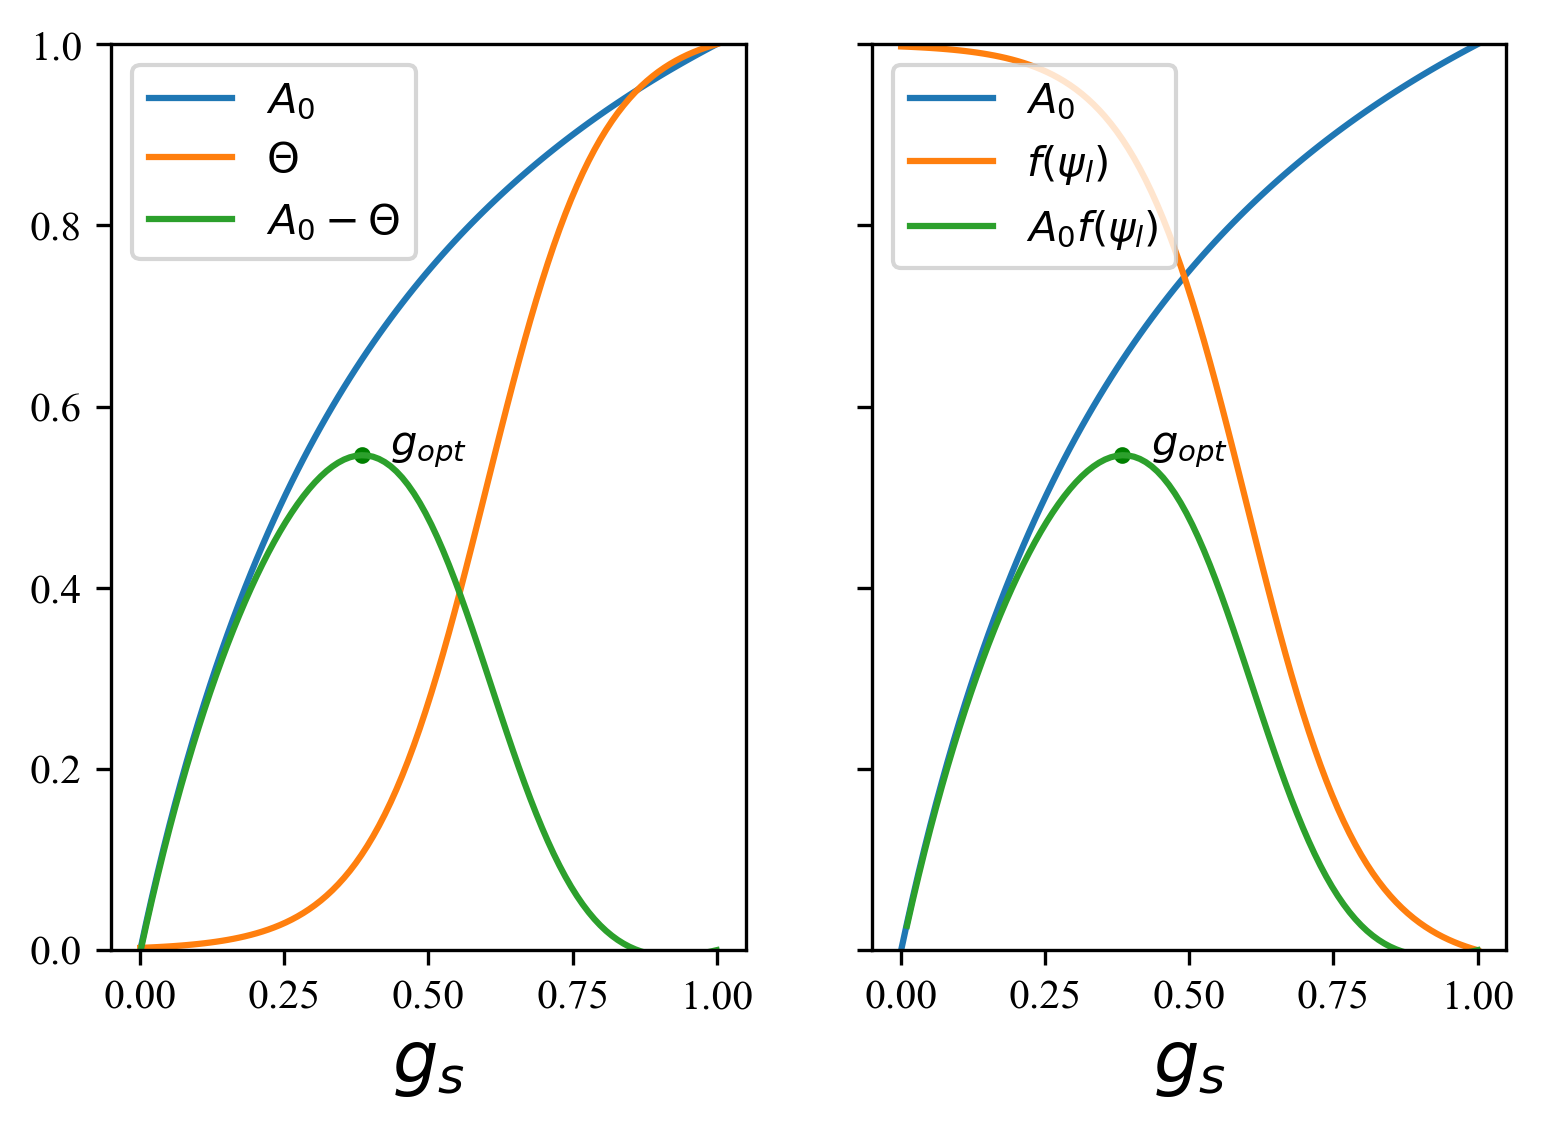

In [ ]:
n = 100
g = np.linspace(0, 1, n)


def A_gs(gs):
    return gs/(gs+1/2)


gss = np.linspace(0, 1, n)

A_arr = [A_gs(i) for i in gss]

A_arr = normalize(A_arr)


def Theta(gs):
    return 1/(1+np.exp(-10*(gs-0.6)))


Theta_arr = [Theta(i) for i in gss]
Theta_arr = normalize(Theta_arr)

fig, ax = plt.subplots(1, 2, sharey=True, dpi=300)

ax[0].plot(gss, A_arr, label=r'$A_0$')
ax[0].plot(gss, Theta_arr, label=r'$\Theta$')
ax[0].plot(gss, A_arr-Theta_arr, label=r'$A_0-\Theta$')

ax[1].plot(gss, A_arr, label=r'$A_0$')
ax[1].plot(gss, (1-Theta_arr), label=r'$f(\psi_l)$')
ax[1].plot(gss, A_arr*(1-Theta_arr/A_arr), label=r'$A_0f(\psi_l)$')


ax[0].legend()
ax[1].legend(loc='upper left')

ax[0].set_ylim(0, 1)

# ax.set_xticks([0,1,max_psi,2,3,4,5],labels=['0','1',r'$|\psi_l^*|$','2','3','4','5'],fontsize='x-large')

ax[0].set_xlabel(r'$g_s$', fontsize='xx-large')
ax[1].set_xlabel(r'$g_s$', fontsize='xx-large')

P = A_arr - Theta_arr
argmax = np.argmax(P)

ax[0].scatter(gss[argmax], P[argmax], marker='.', color='green')
ax[1].scatter(gss[argmax], P[argmax], marker='.', color='green')

ax[0].text(gss[argmax]+0.05, P[argmax], r'$g_{opt}$')
ax[1].text(gss[argmax]+0.05, P[argmax], r'$g_{opt}$')


plt.show()

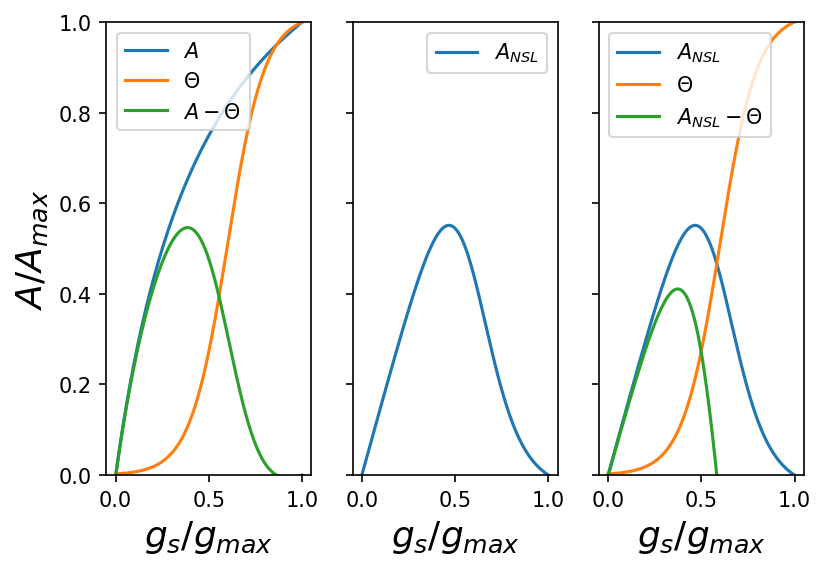

In [ ]:
n = 200
g = np.linspace(0, 1, n)


def A_gs(gs):
    return gs/(gs+1/2)


gss = np.linspace(0, 1, n)

A_arr = [A_gs(i) for i in gss]

A_arr = normalize(A_arr)


def Theta(gs):
    return 1/(1+np.exp(-10*(gs-0.6)))


Theta_arr = [Theta(i) for i in gss]
Theta_arr = normalize(Theta_arr)

# build a rectangle in axes coords
left, width = 0, 1
bottom, height = 0, 1
right = left + width
top = bottom + height

fig, ax = plt.subplots(1, 3, sharey=True, dpi=150)
# ax = fig.add_axes([0, 0, 1, 1])

# axes coordinates: (0, 0) is bottom left and (1, 1) is upper right
# p = patches.Rectangle(
#     (left, bottom), width, height,
#     fill=False, transform=ax.transAxes, clip_on=False
#     )

# ax.add_patch(p)
labels1 = ['A', r'$\Theta', r'A-\Theta']
labels2 = [r'$A_{lin}$', r'$\Theta', r'A_{lin}-\Theta']
labels3 = [r'$A_{NSL}$']

ax[0].plot(gss, A_arr, label=r'$A$')
ax[0].plot(gss, Theta_arr, label=r'$\Theta$')
ax[0].plot(gss, A_arr-Theta_arr, label=r'$A-\Theta$')

ax[1].plot(gss, gss*(1-Theta_arr)*1.5, label=r'$A_{NSL}$')

ax[2].plot(gss, gss*(1-Theta_arr)*1.5, label=r'$A_{NSL}$')
ax[2].plot(gss, Theta_arr, label=r'$\Theta$')
ax[2].plot(gss, gss*(1-Theta_arr)*1.5-Theta_arr, label=r'$A_{NSL}-\Theta$')

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_ylim(0, 1)

# ax.set_xticks([0,1,max_psi,2,3,4,5],labels=['0','1',r'$|\psi_l^*|$','2','3','4','5'],fontsize='x-large')

ax[0].set_ylabel(r'$A/A_{max}$', fontsize='xx-large')
ax[0].set_xlabel(r'$g_s/g_{max}$', fontsize='xx-large')
ax[1].set_xlabel(r'$g_s/g_{max}$', fontsize='xx-large')
ax[2].set_xlabel(r'$g_s/g_{max}$', fontsize='xx-large')


plt.show()

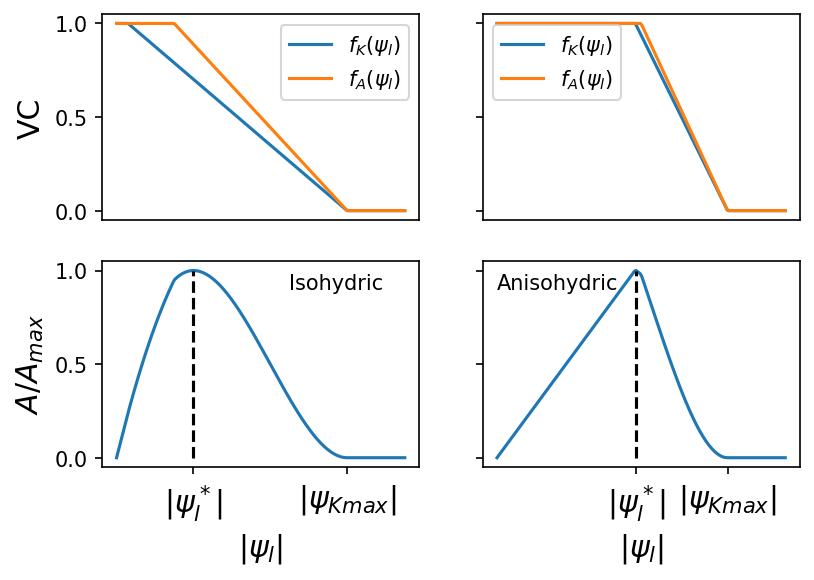

In [ ]:
fig, ax = plt.subplots(2, 2, sharey=True, dpi=150)
n = 200
psi = np.linspace(0, 5, n)
kmin1 = 1
kmin2 = 2.5
kmax = 4
amin1 = 0.2
amin2 = 2.4
amax = 4
out1 = [VC(i, amin1, amax) for i in psi]
out2 = [VC(i, kmin1, kmax) for i in psi]
out3 = [VC(i, amin2, amax) for i in psi]
out4 = [VC(i, kmin2, kmax) for i in psi]

A_arr1 = [A(i, 0, amin1, amax, kmin1, kmax) for i in psi]
A_arr2 = [A(i, 0, amin2, amax, kmin2, kmax) for i in psi]
A_arr1 = normalize(A_arr1)
A_arr2 = normalize(A_arr2)


ax[0, 0].plot(psi, out1, label=r'$f_K(\psi_l)$')
ax[0, 0].plot(psi, out2, label=r'$f_A(\psi_l)$')
ax[0, 0].legend()

ax[0, 1].plot(psi, out3, label=r'$f_K(\psi_l)$')
ax[0, 1].plot(psi, out4, label=r'$f_A(\psi_l)$')
ax[0, 1].legend()

ax[1, 0].plot(psi, A_arr1)
ax[1, 1].plot(psi, A_arr2)

ax[1, 0].text(3, 0.9, 'Isohydric')
ax[1, 1].text(0, 0.9, 'Anisohydric')

ax[1, 0].set_xlabel(r'$|\psi_l|$', fontsize='x-large')
ax[1, 1].set_xlabel(r'$|\psi_l|$', fontsize='x-large')

ax[1, 0].set_ylabel(r'$A/A_{max}$', fontsize='x-large')
ax[0, 0].set_ylabel('VC', fontsize='x-large')


max_psi1 = psi[np.argmax(A_arr1)]
max_psi2 = psi[np.argmax(A_arr2)]

ax[1, 0].vlines(max_psi1, ymin=0, ymax=1, linestyles='dashed', color='black')
ax[1, 1].vlines(max_psi2, ymin=0, ymax=1, linestyles='dashed', color='black')

ax[0, 0].set_xticks([])
ax[0, 1].set_xticks([])


ax[1, 0].set_xticks([max_psi1, kmax], labels=[
                    r'$|\psi_l^*|$', r'$|\psi_{Kmax}|$'], fontsize='x-large')
ax[1, 1].set_xticks([max_psi2, kmax], labels=[
                    r'$|\psi_l^*|$', r'$|\psi_{Kmax}|$'], fontsize='x-large')


plt.show()

# Data Analysis

## psi_J vs psi_V data
from zhou et al. 2014

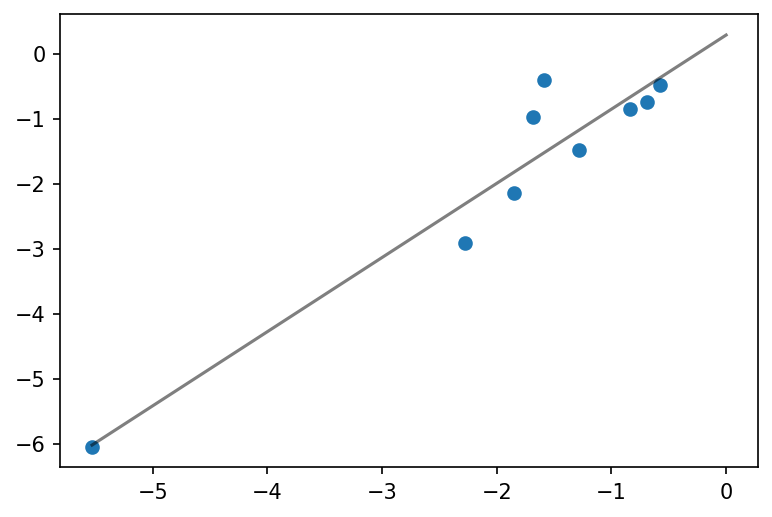

In [ ]:
psi50V = [-5.53, -2.28, -1.28, -1.85, -1.59, -1.68, -0.84, -0.58, -0.69]
psi50J = [-6.05, -2.92, -1.48, -2.15, -0.4, -0.97, -0.85, -0.48, -0.74]

psi50V = np.reshape(psi50V, (9, 1))

x8 = np.linspace(0, min(psi50V), 100)

regr = linear_model.LinearRegression()

regr.fit(psi50V, psi50J)

psi50J_pred = regr.predict(x8)


fig, ax = plt.subplots()
ax.scatter(psi50V, psi50J)

plt.plot(x8, psi50J_pred, color='black', alpha=0.5)

## K vs A data
data from manzoni et al. 2014

In [ ]:
psi50K = [12.49372987677085,
            12.49372987677085,
            7.910771304618727, 
            6.87305987378347, 
            3.848059071628874,
            2.8541102018028477, 
            3.985739455794442, 
            3.7810127555616666, 
            3.4025664524883146, 
            4.723895202861247, 
            5.008936742768258, 
            5.765198292900813, 
            5.249304684378173, 
            3.758924590586161, 
            3.8706710079849502, 
            3.4426722137040207, 
            2.991072720909462, 
            2.465230353256335, 
            2.8708815031355686, 
            2.8208609537968456, 
            2.8708815031355686, 
            2.7394225920976343,
            2.019963451046538,
            2.4081270125596355, 
            1.3802225207854706, 
            1.2640992407606912,
            1.0541459956546386,
            1.1782754237400161,
            3.7810127555616666]

psi50A = [4.022719715650902
    , 3.256205941492482
    , 2.7228784113361066
    , 1.9991595579100438
    , 1.602515577681148
    , 1.1689518164985777
    , 1.3013879455860717
    , 1.3356916613034076
    , 1.849052118176669
    , 2.3752329794565332
    , 2.7855775537831526
    , 3.342037351959217
    , 3.2988425064163645
    , 2.8870345244613924
    , 2.9058743813311736
    , 3.1112710869970517
    , 3.1725788843129394
    , 2.7765329059430437
    , 2.7052249849275336
    , 2.4457838846837476
    , 2.2256538834596835
    , 2.031934033492664
    , 1.8671810912919198
    , 1.7725054149823947
    , 1.6991275774530268
    , 1.58180353721955
    , 1.477377652598511
    , 2.254796461664281
    , 2.55971781121795]

psi50A = np.reshape(psi50A, (len(psi50A), 1))

x7 = np.linspace(0, max(psi50A), 100)

regr = linear_model.LinearRegression()

regr.fit(psi50A, psi50K)

psi50K_pred = regr.predict(x7)

fig, ax = plt.subplots()
ax.scatter(psi50A, psi50K)

plt.plot(x7, psi50K_pred, color='black', alpha=0.5)


## Hydraulic Safety Margin Data
Data from li et al. 2018

In [ ]:
HSM = [1.21,
       0.58,
       0.78,
       0.78,
       1.50,
       0.15,
       1.40,
       1.40,
       1.22,
       1.76,
       3.46,
       3.14,
       1.77]

psiK_dif = [1.27,
            2.67,
            2.54,
            2.54,
            4.21,
            2.82,
            2.49,
            3.28,
            3.75,
            3.37,
            6.74,
            5.22,
            4.17]

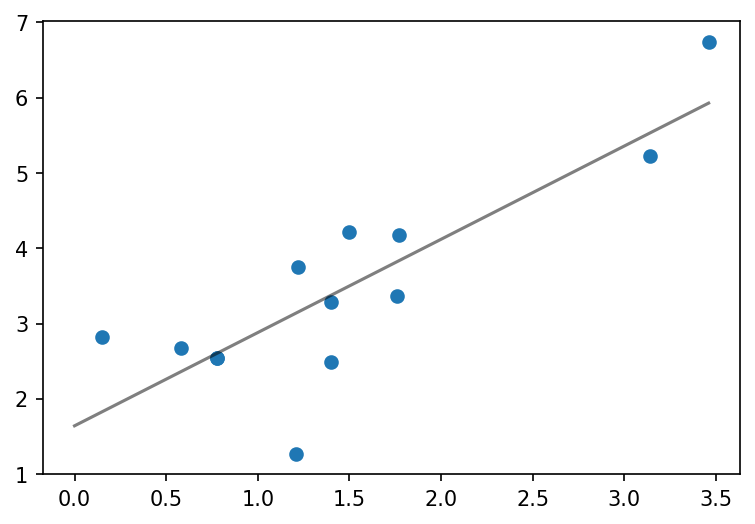

In [ ]:
HSM = np.reshape(HSM, (len(HSM), 1))

x = np.linspace(0, max(HSM), 100)

regr = linear_model.LinearRegression()

regr.fit(HSM, psiK_dif)

psiK_dif_pred = regr.predict(x)

fig, ax = plt.subplots()
ax.scatter(HSM, psiK_dif)

plt.plot(x, psiK_dif_pred, color='black', alpha=0.5)

# Extra

In [ ]:
def dpsi50(psil, psi50):
    return np.exp(-psi50+psil)/((1+np.exp(-psi50+psil))**2)


def logist(psil, psi50):
    return 1/(1+np.exp((psil-psi50)))

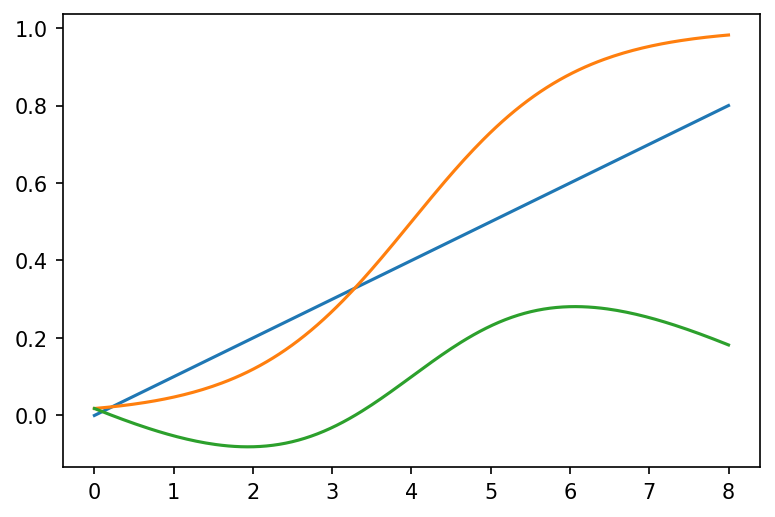

In [ ]:
psi50s = np.linspace(0, 8, n)
out11 = [dpsi50(4, i) for i in psi50s]
out12 = [logist(4, i) for i in psi50s]

fig, ax = plt.subplots()
# ax.plot(psi50s,out11)
# ax.hlines(y=0.1,xmin=0,xmax=8,color='black')
ax.plot(psi50s, psi50s*0.1)
ax.plot(psi50s, out12)
ax.plot(psi50s, out12-psi50s*0.1)

In [ ]:
def equation2(a):
    return np.log(-((2*a-1) - np.sqrt((2*a-1)**2-4*a**2))/(2*a))

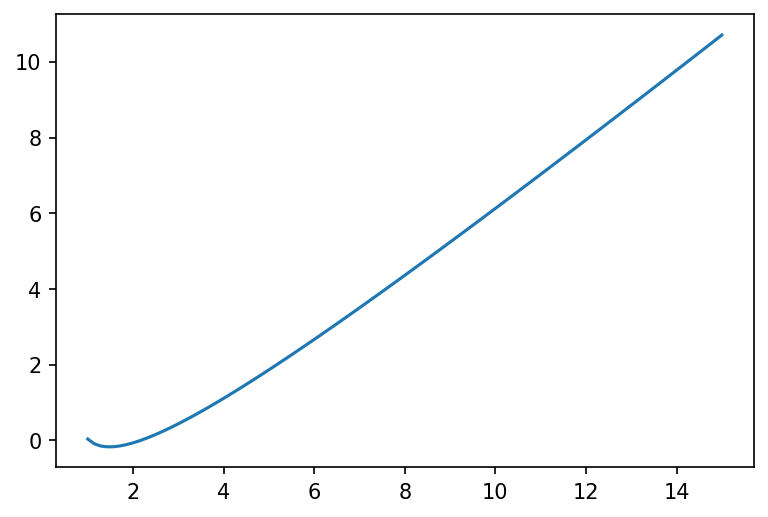

In [ ]:
fig, ax = plt.subplots()
a = np.linspace(0.01, 0.25, n)
psil = np.linspace(1, 15, 100)
out13 = [i-equation2(0.2/i) for i in psil]
ax.plot(psil, out13)

# NSF GRAPHS

In [ ]:
def valleys(x, k, k2):
    return x*(x-k)*(x-k2)*(x-5)

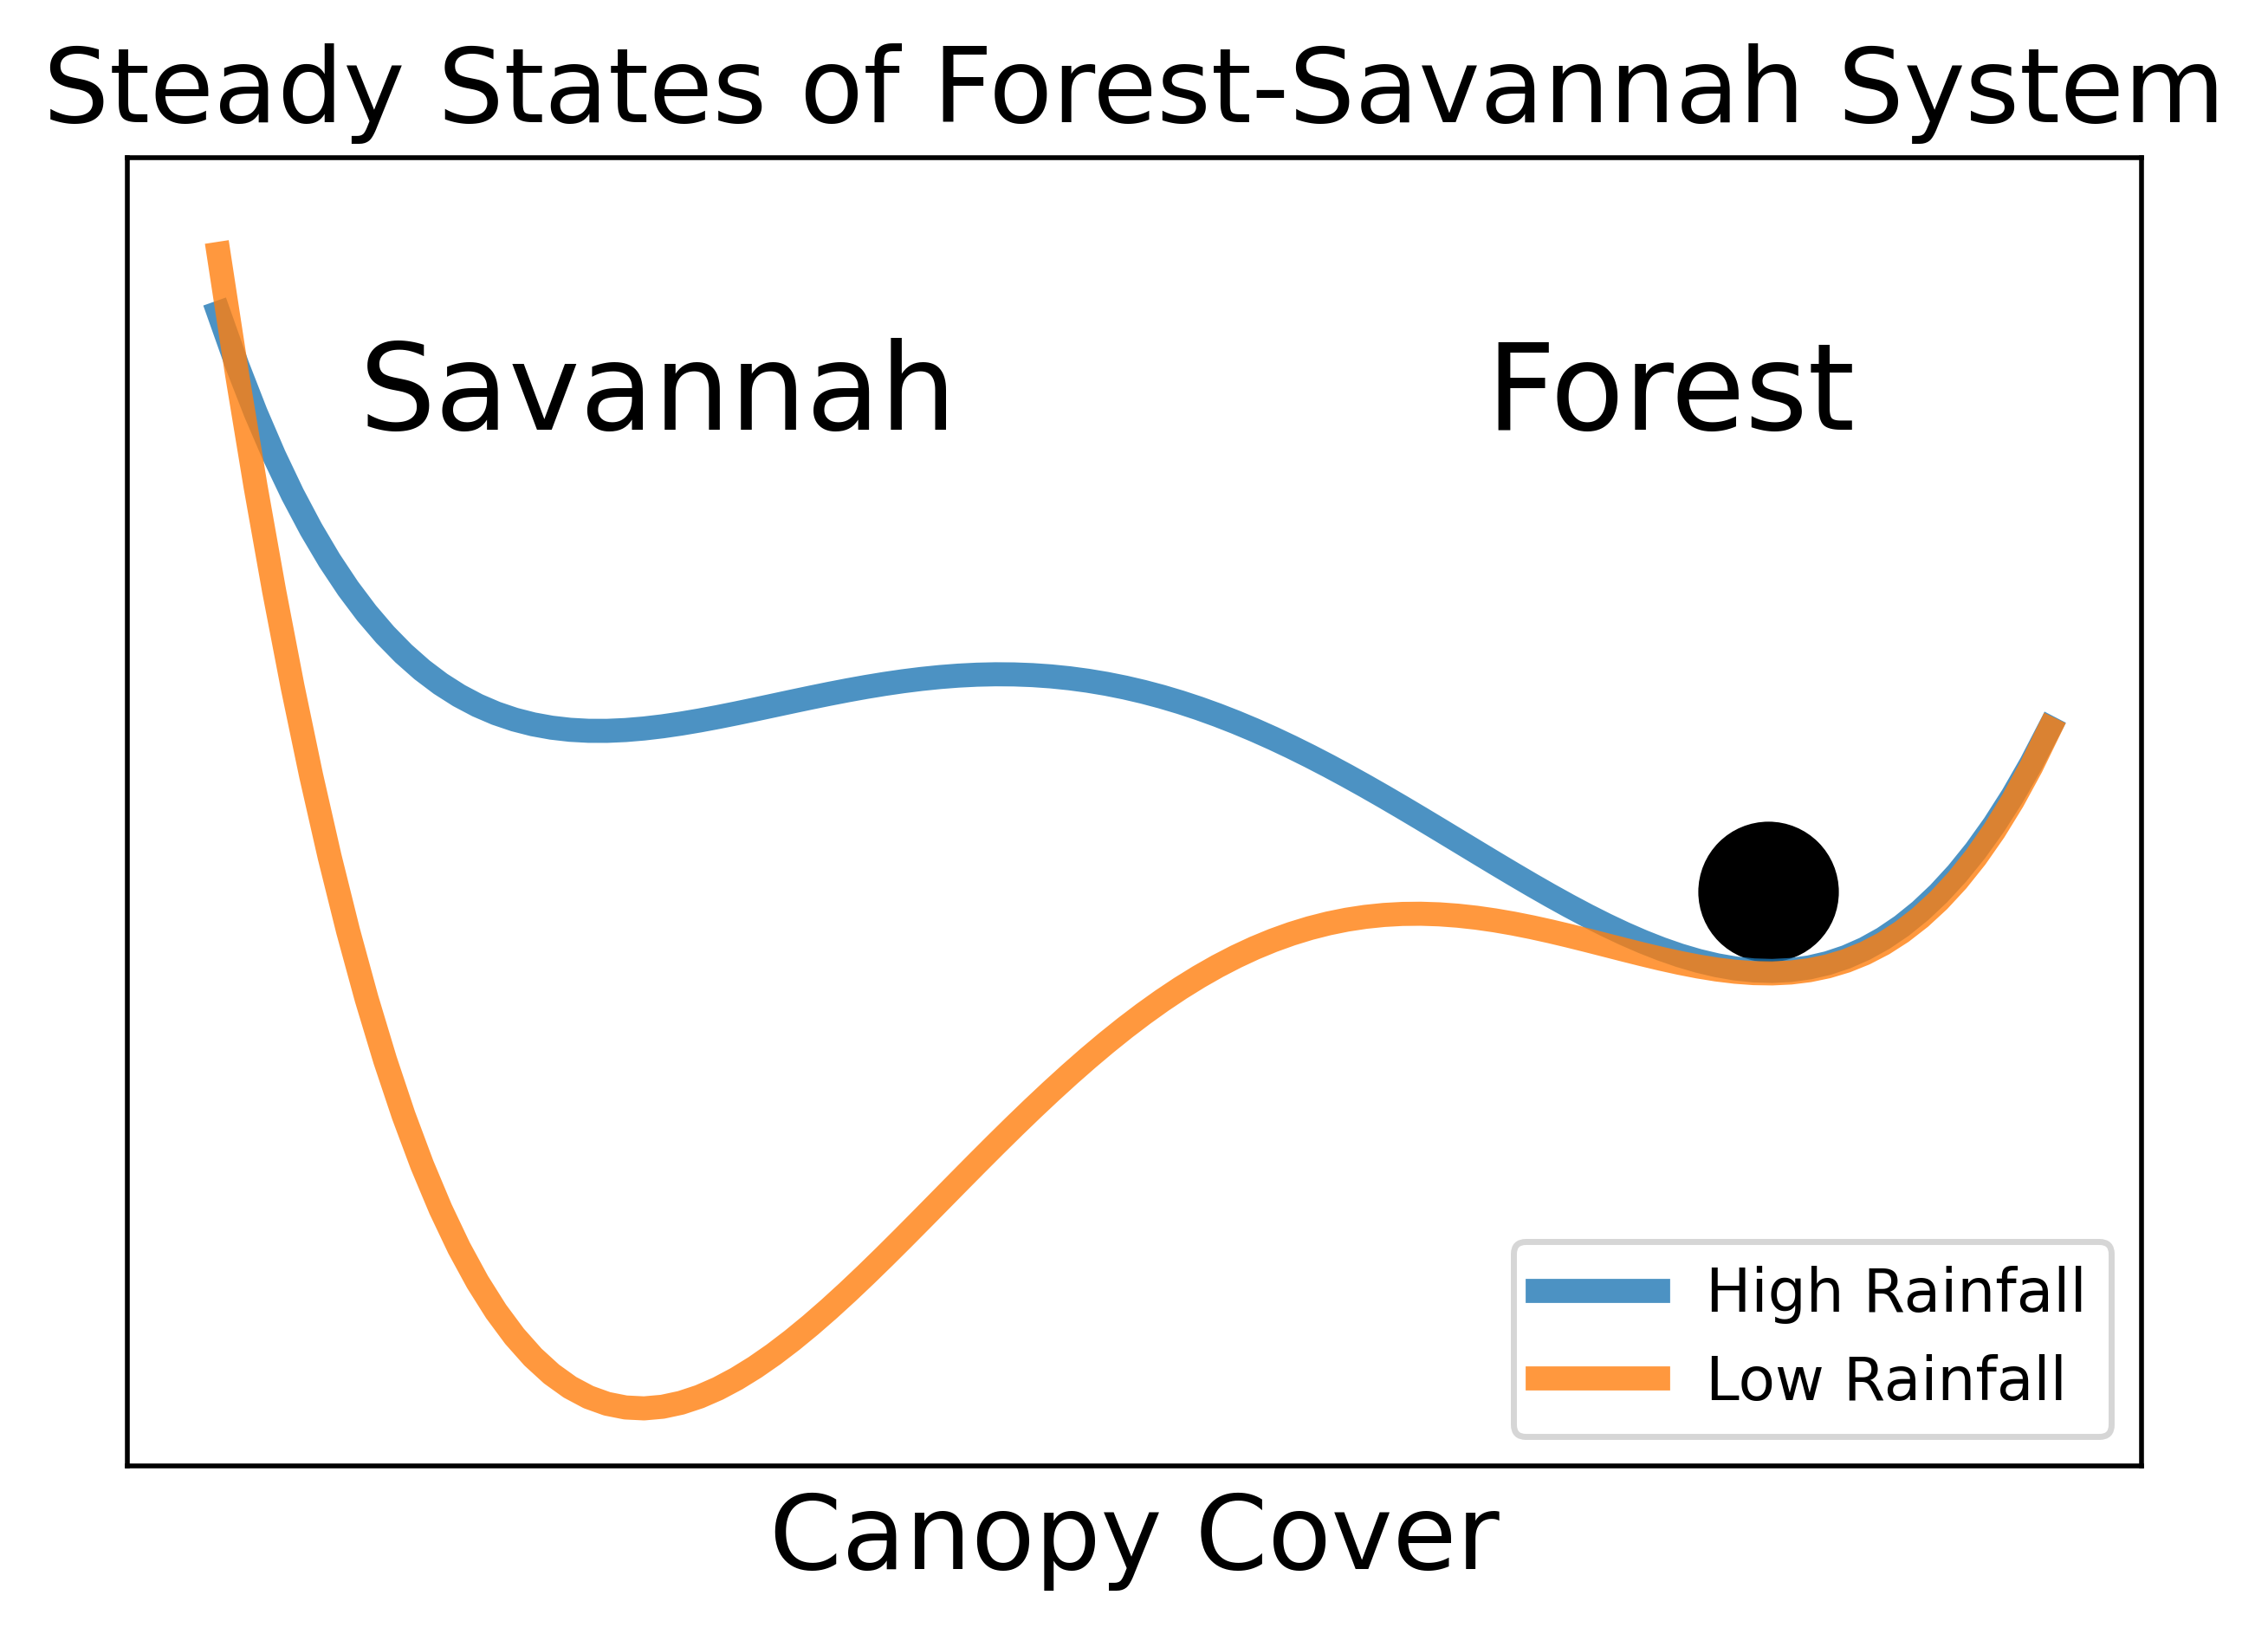

In [ ]:
x = np.linspace(-0.5, 6, 100)
fig, ax = plt.subplots(dpi=500)
ax.plot(x, valleys(x, 0, 5)/2+10*np.exp(-x+1),
        linewidth=4, label='High Rainfall', alpha=0.8)
ax.plot(x, valleys(x, 3, 5), linewidth=4, label='Low Rainfall', alpha=0.8)
ax.set_xticks(ticks=[])
ax.set_yticks(ticks=[])
ax.scatter(5, 6, 500, color='black')
ax.text(4, 40, 'Forest', size=20)
ax.text(0, 40, 'Savannah', size=20)
ax.set_title("Steady States of Forest-Savannah System", size='xx-large')
ax.set_xlabel("Canopy Cover", size="xx-large")
ax.legend(loc='lower right')
ax.set_ylim(top=60)
plt.show()

In [ ]:
def exp(x):
    return np.exp(x)

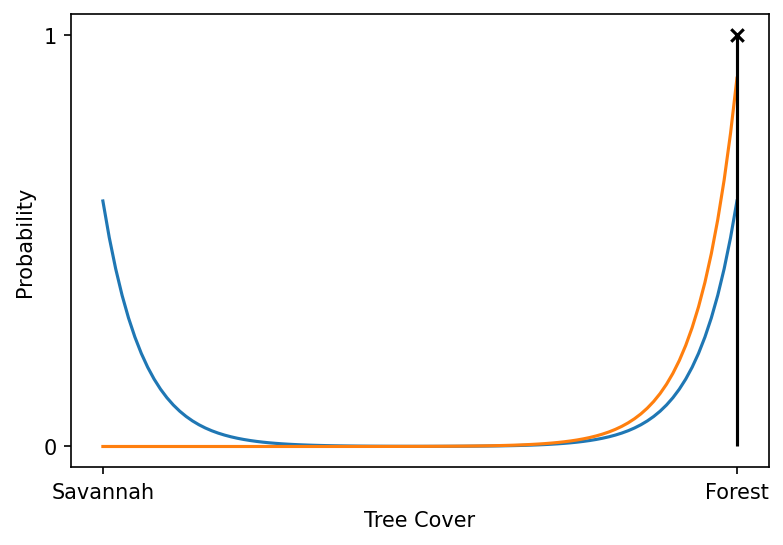

In [ ]:
fig, ax = plt.subplots()
x = np.linspace(-8, 8, 100)
ax.plot(x, exp(x)+exp(-x))
ax.plot(x, exp(x)*1.5)

ax.vlines(x=8, ymin=0, ymax=5000, color='black')
ax.scatter(8, 5000, marker='x', color='black')

ax.set_ylabel('Probability')
ax.set_xticks([-8, 8])
ax.set_xticklabels(['Savannah', 'Forest'])
ax.set_xlabel("Tree Cover")
ax.set_yticks([0, 5000])
ax.set_yticklabels([0, 1])
plt.show()

In [ ]:
import scipy.integrate as integrate

In [ ]:

def integrand(k1, k2, alpha, F, x):
    def h(x):
        return alpha*x*(1-x)
    return k1/(h(x))+k2/(h(x)-x*F)

In [ ]:
k1 = 0.5
k2 = 0.5
alpha = 1
Fe = 1.1

ans1, ans2 = integrate.quad(lambda x: integrand(k1, k2, alpha, Fe, x), 0, 1)

C:\Users\amatt\AppData\Local\Temp\ipykernel_14532\586871936.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  ans1, ans2 = integrate.quad(lambda x: integrand(k1, k2, alpha, Fe, x), 0, 1)


In [ ]:
np.exp(ans1)

1.2226602533569374e-73

In [ ]:
def function(x):
    h = alpha*x*(1-x)
    return (F/(h*(h-x*F)))*np.exp(scipy.)

SyntaxError: invalid syntax (3201187006.py, line 3)

In [ ]:
def pdf(k1, k2, a, F, v):
    
    def h(x):
        return alpha*x*(1-x)

    def pdf_0(k1, k2, a, F, v):
        return F/(h(v)*(h(v)-v*F)) * (1/v-1)**(-k1/a) * (v*(a*v+F-a))**(-k2/(F-a))
    
    area = integrate.quad(lambda x: np.real(pdf_0(k1, k2, a, F, x)), min(x), max(x))[0]
    return pdf_0(k1, k2, a, F, v)/(area)

def pdf_0(k1, k2, a, F, v):
    def h(x):
        return alpha*x*(1-x)
    return F/(h(v)*(h(v)-v*F)) * (1/v-1)**(-k1/a) * (v*(a*v+F-a))**(-k2/(F-a))

def pdf_fb(a, F, v):
    def h(x):
        return alpha*x*(1-x)
    return F/(h(v)*(h(v)-v*F)) * v**(-a) * (a*(v-1)+F)**a

In [ ]:
pdf(1,2,3,1,0.5)

0.28451851364673775

In [ ]:
import scipy.stats as stats

In [ ]:
fig, ax = plt.subplots(dpi=1)
mpl.rc('font', family='Times New Roman')
mu = 0.4

sd1 = 1
sd2 = 2
sd3 = 0.5
font1 = {'family': "calibri"}

x = np.linspace(stats.norm.ppf(0.0001, mu, sd1),
                stats.norm.ppf(0.9999, mu, sd1), 1000)

x2 = np.linspace(stats.norm.ppf(0.0001, mu, sd2),
                 stats.norm.ppf(0.9999, mu, sd2), 100)


x3 = np.linspace(stats.norm.ppf(0.0001, mu, sd3),
                 stats.norm.ppf(0.9999, mu, sd3), 100)


ax.plot(x3, stats.norm.pdf(x3, mu, sd3),
        'g-', lw=3, alpha=0.6, label=r'$\sigma^2=1/2$')

ax.plot(x, stats.norm.pdf(x, mu, sd1),
        'b-', lw=3, alpha=0.6, label=r'$\sigma^2=1$')

ax.plot(x2, stats.norm.pdf(x2, mu, sd2),
        'r-', lw=3, alpha=0.6, label=r'$\sigma^2=2$')


Rf = -1
ax.vlines(x=Rf, ymin=0, ymax=0.6, color='black', lw=1, linestyles='--')
ax.vlines(x=mu, ymin=0, ymax=0.6, color='black', lw=1)


xfill = np.linspace(-10, Rf, 1000)

ax.fill_between(xfill, 0, stats.norm.pdf(xfill, mu, sd1), alpha=0.2)

ax.fill_between(xfill, 0, stats.norm.pdf(xfill, mu, sd2), alpha=0.2)

ax.fill_between(xfill, 0, stats.norm.pdf(xfill, mu, sd3), alpha=0.2)

# ax.text(-4.5,0.35,r'$p$',color='green')
# ax.text(-3.8,0.35,r'$p$ ',color='blue')
# ax.text(-3.2,0.35,r'$p $ ',color='red')

ax.legend(loc='upper right', title='Variance',
          title_fontsize='x-large', fontsize='large')
ax.set_xlim(left=-5, right=4)
ax.set_xticks([Rf, mu])
ax.set_xticklabels([r'$R_f$', 'MAP'], size='xx-large',
                   fontname='Times New Roman')

# ax.set_xticklabels([r'$R_f$'],size='x-large')

# ext(Rf-1,0.2,r'$R_f$',size='x-large',rotation=90)

# ax.set_xlabel("Rainfall",size='x-large')
ax.set_yticks([])
ax.set_ylabel("Probability", fontsize=25, fontname='Times New Roman')

ax.set_title("PDF of Rainfall, 3 Variances",
             fontsize=25, fontname='Times New Roman')
ax.set_ylim(bottom=0, top=0.6)


plt.show()

RuntimeError: In set_size: Could not set the fontsize (error code 0x97)

<Figure size 6x4 with 1 Axes>

In [ ]:
mean, var, skew, kurt = stats.lognorm.stats(s2, loc, scale, moments='mvsk')
mean

array(3.55524263)

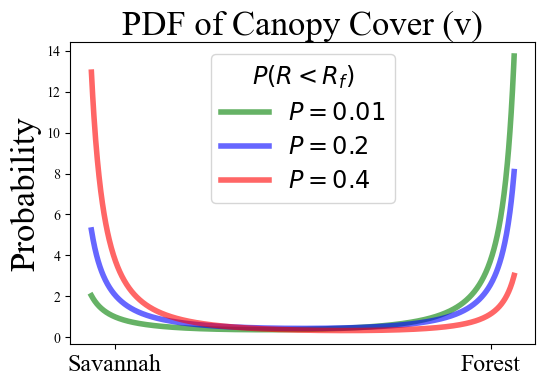

In [ ]:
x = np.linspace(0.05, 0.95, 1000)
fig, ax = plt.subplots(dpi=100)
ax.plot(x, pdf(0.99, 0.1, 1, 2, x), label=r'$P=0.01$',linewidth=4, alpha=0.6, color='green')
ax.plot(x, pdf(0.8, 0.2, 1, 2, x), label=r'$P=0.2$', linewidth=4, alpha=0.6, color='blue')
ax.plot(x, pdf(0.6, 0.4, 1, 2, x), label=r'$P=0.4$',linewidth=4, alpha=0.6, color='red')

# ax.set_ylim(0,5)
ax.set_ylabel('Probability', fontsize=25)
ax.set_xticks([0.1, 0.9])
ax.set_xticklabels(['Savannah', 'Forest'], size='xx-large')
# ax.set_xlabel("Canopy Cover",size='xx-large')
# ax.set_yticks([])
ax.legend(title=r'$P(R<R_f)$', title_fontsize='xx-large', fontsize='xx-large')
ax.set_title("PDF of Canopy Cover (v)", fontsize=25)
# ax.set_yticklabels([0,1])
plt.show()

C:\Users\amatt\AppData\Local\Temp\ipykernel_14532\3457898233.py:7: RuntimeWarning: invalid value encountered in power
  return F/(h(v)*(h(v)-v*F)) * (1/v-1)**(-k1/a) * (v*(a*v+F-a))**(-k2/(F-a))


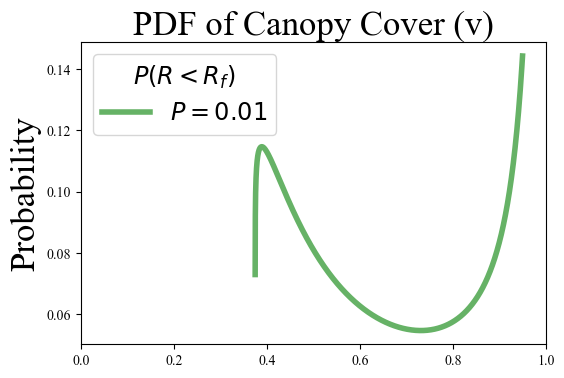

In [ ]:
x = np.linspace(0.05, 0.95, 10000)
fig, ax = plt.subplots(dpi=100)
F = 1
a = 1.6
ax.plot(x, pdf(0.01, 0.05, a, F, x), label=r'$P=0.01$',linewidth=4, alpha=0.6, color='green')
#ax.plot(x, pdf(0.9, 0.1, 1, 2, x)/30, label=r'$P=0.2$', linewidth=4, alpha=0.6, color='blue')
#ax.plot(x, pdf(0.6, 0.4, 1, 2, x), label=r'$P=0.4$',linewidth=4, alpha=0.6, color='red')

# ax.set_ylim(0,5)
ax.set_ylabel('Probability', fontsize=25)
#ax.set_xticks([0.1, 0.5,0.9])
#ax.vlines(x=1-(F/a),ymin=0,ymax=0.18,color='green',linewidth=4,alpha=0.6)
#ax.set_xticklabels(['Grassland','Savannah', 'Forest'], size='xx-large')
# ax.set_xlabel("Canopy Cover",size='xx-large')
ax.set_xlim(left=0,right=1)
#ax.set_yticks([])
ax.legend(title=r'$P(R<R_f)$', title_fontsize='xx-large', fontsize='xx-large')
ax.set_title("PDF of Canopy Cover (v)", fontsize=25)
# ax.set_yticklabels([0,1])
plt.show()

In [ ]:
1-F/a

0.375

In [ ]:
def temp(T1, f):
    # T1=253
    S = 1.74*10**17
    sig = 5.78*10**-8
    A = 5.10*10**14
    T2 = ((T1**4+(S/(sig*A))*(1-f))/f)**(1/4)
    return (T2-T1)/T1 * 100

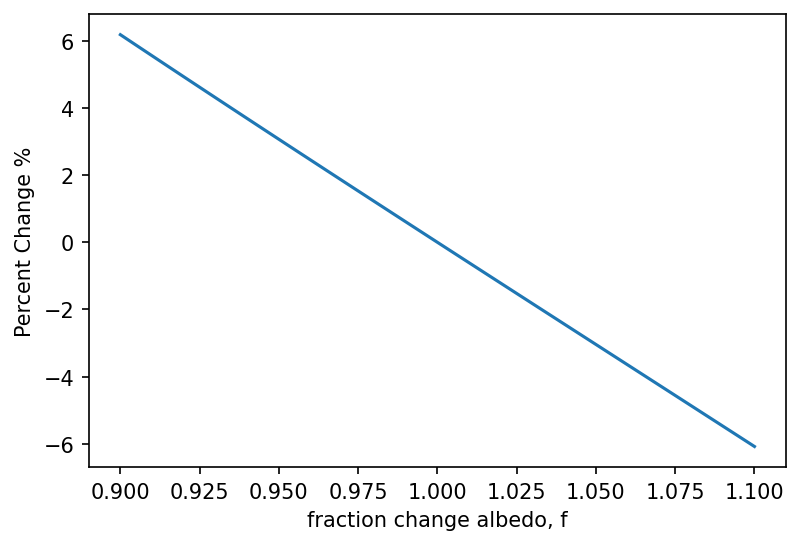

In [ ]:
fs = np.linspace(0.90, 1.1, 100)
fig, ax = plt.subplots()
ax.plot(fs, temp(253, fs))
# ax.plot(fs,temp(300,fs))
ax.set_xlabel("fraction change albedo, f")
ax.set_ylabel("Percent Change %")
plt.show()

In [ ]:
hs = np.arccos(-np.tan(np.pi/4)*np.tan(23.439*np.pi/180))
Rs = 1366
w = 2*np.pi
phi = np.pi/4
delt = 23.439*np.pi/180

In [ ]:
Q = (2*Rs/w)*(np.cos(phi)*np.sin(hs)*np.cos(delt)+hs*np.sin(phi)*np.sin(delt))

In [ ]:
Rscmd = 477 * 4.184 * 100**2 / (3600*24)  # cal/cm^2/day
al = 0.2
epss = 0.97
epsac = 0.817
Ta = 20.45+273.15
sig = 5.78*10**-8
Rn = Rscmd * (1-al) + epss*sig*Ta**4*(epsac-1)

In [ ]:
Rn

108.55474126560837

In [ ]:
fig, ax = plt.subplots()
s = 0.4
s2 = 0.7
loc = 1
scale = 2

x = np.linspace(stats.lognorm.ppf(0.01, s, loc, scale),
                stats.lognorm.ppf(0.99, s, loc, scale), 100)

x2 = np.linspace(stats.lognorm.ppf(0.01, s2, loc, scale),
                 stats.lognorm.ppf(0.99, s2, loc, scale), 100)

ax.plot(x, stats.lognorm.pdf(x, s, loc, scale),
        'b-', lw=3, alpha=0.6, label='lognorm pdf')

ax.plot(x2, stats.lognorm.pdf(x2, s2, loc, scale),
        'r-', lw=3, alpha=0.6, label='lognorm pdf')

In [ ]:
def sol2(k1,k2,a,F,v):
    return (1/(a*v*(1-v)) - 1/((a-F)*v*(1-v))) * (1-v)**(k1/a) * v**(k2*(a-F))

C:\Users\amatt\AppData\Local\Temp\ipykernel_14532\377018530.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return (1/(a*v*(1-v)) - 1/((a-F)*v*(1-v))) * (1-v)**(k1/a) * v**(k2*(a-F))
C:\Users\amatt\AppData\Local\Temp\ipykernel_14532\377018530.py:2: RuntimeWarning: invalid value encountered in subtract
  return (1/(a*v*(1-v)) - 1/((a-F)*v*(1-v))) * (1-v)**(k1/a) * v**(k2*(a-F))


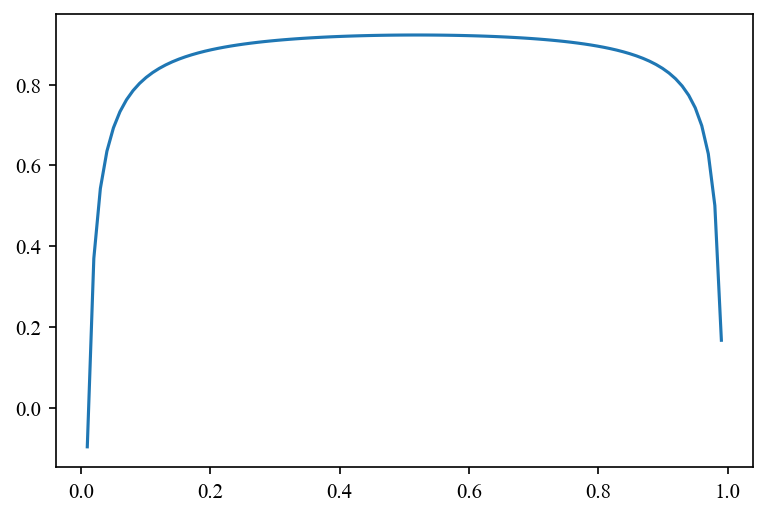

In [ ]:
x = np.linspace(0,1,100)
fig, ax = plt.subplots()
ax.plot(x,1+sol2(0.5,0.1,2,0.1,x))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

NameError: name 'logistic' is not defined

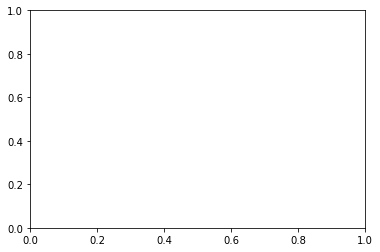

In [ ]:
x = np.linspace(0,6,100)
fig, ax = plt.subplots()
ax.plot(x,logistic(x,3,1))
ax.plot(x,logistic(x,3,1)*logistic(x,3,1))

In [ ]:
def ustar():
